In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:36 - loss: 2.3646 - STD: 0.0903 - MAE: 0.2238

 5/78 [>.............................] - ETA: 1s - loss: 1.6866 - STD: 0.1354 - MAE: 0.1777  

 9/78 [==>...........................] - ETA: 1s - loss: 1.5587 - STD: 0.1852 - MAE: 0.1542

13/78 [====>.........................] - ETA: 1s - loss: 1.4950 - STD: 0.1931 - MAE: 0.1494

17/78 [=====>........................] - ETA: 0s - loss: 1.4634 - STD: 0.1880 - MAE: 0.1506

21/78 [=======>......................] - ETA: 0s - loss: 1.4410 - STD: 0.1874 - MAE: 0.1503

25/78 [========>.....................] - ETA: 0s - loss: 1.4243 - STD: 0.1906 - MAE: 0.1486

29/78 [==========>...................] - ETA: 0s - loss: 1.4104 - STD: 0.1928 - MAE: 0.1474

33/78 [===========>..................] - ETA: 0s - loss: 1.3999 - STD: 0.1924 - MAE: 0.1473

37/78 [=============>................] - ETA: 0s - loss: 1.3905 - STD: 0.1911 - MAE: 0.1475

41/78 [==============>...............] - ETA: 0s - loss: 1.3839 - STD: 0.1908 - MAE: 0.1474

45/78 [================>.............] - ETA: 0s - loss: 1.3781 - STD: 0.1912 - MAE: 0.1471

49/78 [=================>............] - ETA: 0s - loss: 1.3727 - STD: 0.1915 - MAE: 0.1468

53/78 [===================>..........] - ETA: 0s - loss: 1.3676 - STD: 0.1915 - MAE: 0.1467

55/78 [====================>.........] - ETA: 0s - loss: 1.3663 - STD: 0.1915 - MAE: 0.1466

59/78 [=====================>........] - ETA: 0s - loss: 1.3631 - STD: 0.1916 - MAE: 0.1465

63/78 [=======================>......] - ETA: 0s - loss: 1.3599 - STD: 0.1916 - MAE: 0.1465

67/78 [========================>.....] - ETA: 0s - loss: 1.3575 - STD: 0.1915 - MAE: 0.1464

71/78 [==========================>...] - ETA: 0s - loss: 1.3550 - STD: 0.1915 - MAE: 0.1464

75/78 [===========================>..] - ETA: 0s - loss: 1.3530 - STD: 0.1915 - MAE: 0.1463

78/78 [==============================] - 4s 32ms/step - loss: 1.3515 - STD: 0.1915 - MAE: 0.1463 - val_loss: 1.2732 - val_STD: 0.1918 - val_MAE: 0.1449


Epoch 2/10000


 1/78 [..............................] - ETA: 3s - loss: 1.3166 - STD: 0.1918 - MAE: 0.1453

 4/78 [>.............................] - ETA: 1s - loss: 1.3169 - STD: 0.1910 - MAE: 0.1455

 8/78 [==>...........................] - ETA: 1s - loss: 1.3183 - STD: 0.1911 - MAE: 0.1456

12/78 [===>..........................] - ETA: 0s - loss: 1.3153 - STD: 0.1915 - MAE: 0.1453

16/78 [=====>........................] - ETA: 0s - loss: 1.3155 - STD: 0.1917 - MAE: 0.1452

20/78 [======>.......................] - ETA: 0s - loss: 1.3151 - STD: 0.1916 - MAE: 0.1452

24/78 [========>.....................] - ETA: 0s - loss: 1.3149 - STD: 0.1916 - MAE: 0.1452

28/78 [=========>....................] - ETA: 0s - loss: 1.3138 - STD: 0.1914 - MAE: 0.1453

32/78 [===========>..................] - ETA: 0s - loss: 1.3125 - STD: 0.1913 - MAE: 0.1452

36/78 [============>.................] - ETA: 0s - loss: 1.3117 - STD: 0.1913 - MAE: 0.1452

40/78 [==============>...............] - ETA: 0s - loss: 1.3110 - STD: 0.1912 - MAE: 0.1452

44/78 [===============>..............] - ETA: 0s - loss: 1.3093 - STD: 0.1912 - MAE: 0.1451

48/78 [=================>............] - ETA: 0s - loss: 1.3076 - STD: 0.1913 - MAE: 0.1450

51/78 [==================>...........] - ETA: 0s - loss: 1.3063 - STD: 0.1914 - MAE: 0.1449

55/78 [====================>.........] - ETA: 0s - loss: 1.3044 - STD: 0.1914 - MAE: 0.1448

59/78 [=====================>........] - ETA: 0s - loss: 1.3020 - STD: 0.1917 - MAE: 0.1445

63/78 [=======================>......] - ETA: 0s - loss: 1.2998 - STD: 0.1918 - MAE: 0.1444

67/78 [========================>.....] - ETA: 0s - loss: 1.2967 - STD: 0.1921 - MAE: 0.1441

71/78 [==========================>...] - ETA: 0s - loss: 1.2938 - STD: 0.1924 - MAE: 0.1439

75/78 [===========================>..] - ETA: 0s - loss: 1.2910 - STD: 0.1926 - MAE: 0.1437

78/78 [==============================] - 1s 18ms/step - loss: 1.2885 - STD: 0.1928 - MAE: 0.1435 - val_loss: 1.1938 - val_STD: 0.2033 - val_MAE: 0.1367


Epoch 3/10000


 1/78 [..............................] - ETA: 3s - loss: 1.2314 - STD: 0.2018 - MAE: 0.1381

 4/78 [>.............................] - ETA: 1s - loss: 1.2219 - STD: 0.1999 - MAE: 0.1384

 8/78 [==>...........................] - ETA: 1s - loss: 1.2138 - STD: 0.1994 - MAE: 0.1383

12/78 [===>..........................] - ETA: 1s - loss: 1.2099 - STD: 0.1996 - MAE: 0.1381

16/78 [=====>........................] - ETA: 0s - loss: 1.2072 - STD: 0.1998 - MAE: 0.1381

20/78 [======>.......................] - ETA: 0s - loss: 1.2023 - STD: 0.2000 - MAE: 0.1379

24/78 [========>.....................] - ETA: 0s - loss: 1.1992 - STD: 0.1999 - MAE: 0.1379

28/78 [=========>....................] - ETA: 0s - loss: 1.1953 - STD: 0.1999 - MAE: 0.1378

32/78 [===========>..................] - ETA: 0s - loss: 1.1923 - STD: 0.2002 - MAE: 0.1377

36/78 [============>.................] - ETA: 0s - loss: 1.1886 - STD: 0.2001 - MAE: 0.1376

40/78 [==============>...............] - ETA: 0s - loss: 1.1856 - STD: 0.2002 - MAE: 0.1376

44/78 [===============>..............] - ETA: 0s - loss: 1.1822 - STD: 0.2004 - MAE: 0.1374

48/78 [=================>............] - ETA: 0s - loss: 1.1801 - STD: 0.2004 - MAE: 0.1374

52/78 [===================>..........] - ETA: 0s - loss: 1.1771 - STD: 0.2004 - MAE: 0.1373

56/78 [====================>.........] - ETA: 0s - loss: 1.1733 - STD: 0.2006 - MAE: 0.1371

60/78 [======================>.......] - ETA: 0s - loss: 1.1688 - STD: 0.2008 - MAE: 0.1369

64/78 [=======================>......] - ETA: 0s - loss: 1.1654 - STD: 0.2010 - MAE: 0.1367

68/78 [=========================>....] - ETA: 0s - loss: 1.1611 - STD: 0.2012 - MAE: 0.1365

72/78 [==========================>...] - ETA: 0s - loss: 1.1573 - STD: 0.2012 - MAE: 0.1364

76/78 [============================>.] - ETA: 0s - loss: 1.1532 - STD: 0.2014 - MAE: 0.1361

78/78 [==============================] - 1s 18ms/step - loss: 1.1511 - STD: 0.2016 - MAE: 0.1360 - val_loss: 1.0547 - val_STD: 0.2052 - val_MAE: 0.1315


Epoch 4/10000


 1/78 [..............................] - ETA: 3s - loss: 1.0839 - STD: 0.2035 - MAE: 0.1323

 5/78 [>.............................] - ETA: 1s - loss: 1.0708 - STD: 0.2072 - MAE: 0.1306

 9/78 [==>...........................] - ETA: 1s - loss: 1.0677 - STD: 0.2079 - MAE: 0.1303

13/78 [====>.........................] - ETA: 0s - loss: 1.0649 - STD: 0.2073 - MAE: 0.1305

17/78 [=====>........................] - ETA: 0s - loss: 1.0620 - STD: 0.2079 - MAE: 0.1302

21/78 [=======>......................] - ETA: 0s - loss: 1.0595 - STD: 0.2083 - MAE: 0.1299

25/78 [========>.....................] - ETA: 0s - loss: 1.0565 - STD: 0.2086 - MAE: 0.1296

29/78 [==========>...................] - ETA: 0s - loss: 1.0531 - STD: 0.2088 - MAE: 0.1294

33/78 [===========>..................] - ETA: 0s - loss: 1.0506 - STD: 0.2092 - MAE: 0.1292

37/78 [=============>................] - ETA: 0s - loss: 1.0485 - STD: 0.2095 - MAE: 0.1290

41/78 [==============>...............] - ETA: 0s - loss: 1.0465 - STD: 0.2098 - MAE: 0.1288

45/78 [================>.............] - ETA: 0s - loss: 1.0443 - STD: 0.2099 - MAE: 0.1286

49/78 [=================>............] - ETA: 0s - loss: 1.0417 - STD: 0.2102 - MAE: 0.1284

53/78 [===================>..........] - ETA: 0s - loss: 1.0389 - STD: 0.2104 - MAE: 0.1282

57/78 [====================>.........] - ETA: 0s - loss: 1.0366 - STD: 0.2108 - MAE: 0.1279

61/78 [======================>.......] - ETA: 0s - loss: 1.0342 - STD: 0.2111 - MAE: 0.1277

65/78 [========================>.....] - ETA: 0s - loss: 1.0319 - STD: 0.2113 - MAE: 0.1275

70/78 [=========================>....] - ETA: 0s - loss: 1.0292 - STD: 0.2118 - MAE: 0.1271

74/78 [===========================>..] - ETA: 0s - loss: 1.0267 - STD: 0.2120 - MAE: 0.1269

78/78 [==============================] - ETA: 0s - loss: 1.0239 - STD: 0.2122 - MAE: 0.1267

78/78 [==============================] - 1s 18ms/step - loss: 1.0239 - STD: 0.2122 - MAE: 0.1267 - val_loss: 0.9591 - val_STD: 0.2120 - val_MAE: 0.1239


Epoch 5/10000


 1/78 [..............................] - ETA: 3s - loss: 0.9790 - STD: 0.2131 - MAE: 0.1244

 4/78 [>.............................] - ETA: 1s - loss: 0.9754 - STD: 0.2160 - MAE: 0.1229

 8/78 [==>...........................] - ETA: 1s - loss: 0.9707 - STD: 0.2172 - MAE: 0.1222

12/78 [===>..........................] - ETA: 1s - loss: 0.9685 - STD: 0.2184 - MAE: 0.1215

16/78 [=====>........................] - ETA: 0s - loss: 0.9661 - STD: 0.2185 - MAE: 0.1213

20/78 [======>.......................] - ETA: 0s - loss: 0.9630 - STD: 0.2185 - MAE: 0.1212

24/78 [========>.....................] - ETA: 0s - loss: 0.9612 - STD: 0.2185 - MAE: 0.1212

28/78 [=========>....................] - ETA: 0s - loss: 0.9592 - STD: 0.2189 - MAE: 0.1209

32/78 [===========>..................] - ETA: 0s - loss: 0.9566 - STD: 0.2190 - MAE: 0.1207

36/78 [============>.................] - ETA: 0s - loss: 0.9541 - STD: 0.2191 - MAE: 0.1205

40/78 [==============>...............] - ETA: 0s - loss: 0.9516 - STD: 0.2194 - MAE: 0.1203

44/78 [===============>..............] - ETA: 0s - loss: 0.9494 - STD: 0.2196 - MAE: 0.1201

48/78 [=================>............] - ETA: 0s - loss: 0.9461 - STD: 0.2200 - MAE: 0.1198

52/78 [===================>..........] - ETA: 0s - loss: 0.9435 - STD: 0.2201 - MAE: 0.1196

56/78 [====================>.........] - ETA: 0s - loss: 0.9408 - STD: 0.2204 - MAE: 0.1194

60/78 [======================>.......] - ETA: 0s - loss: 0.9375 - STD: 0.2207 - MAE: 0.1191

64/78 [=======================>......] - ETA: 0s - loss: 0.9349 - STD: 0.2211 - MAE: 0.1188

68/78 [=========================>....] - ETA: 0s - loss: 0.9328 - STD: 0.2214 - MAE: 0.1186

72/78 [==========================>...] - ETA: 0s - loss: 0.9308 - STD: 0.2216 - MAE: 0.1184

76/78 [============================>.] - ETA: 0s - loss: 0.9287 - STD: 0.2218 - MAE: 0.1183

78/78 [==============================] - 1s 18ms/step - loss: 0.9281 - STD: 0.2219 - MAE: 0.1182 - val_loss: 0.8855 - val_STD: 0.2192 - val_MAE: 0.1175


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8894 - STD: 0.2221 - MAE: 0.1163

 5/78 [>.............................] - ETA: 1s - loss: 0.8990 - STD: 0.2264 - MAE: 0.1150

 9/78 [==>...........................] - ETA: 1s - loss: 0.8948 - STD: 0.2257 - MAE: 0.1151

13/78 [====>.........................] - ETA: 0s - loss: 0.8938 - STD: 0.2266 - MAE: 0.1147

17/78 [=====>........................] - ETA: 0s - loss: 0.8917 - STD: 0.2266 - MAE: 0.1147

21/78 [=======>......................] - ETA: 0s - loss: 0.8904 - STD: 0.2267 - MAE: 0.1146

25/78 [========>.....................] - ETA: 0s - loss: 0.8876 - STD: 0.2269 - MAE: 0.1144

29/78 [==========>...................] - ETA: 0s - loss: 0.8863 - STD: 0.2272 - MAE: 0.1142

33/78 [===========>..................] - ETA: 0s - loss: 0.8848 - STD: 0.2272 - MAE: 0.1141

37/78 [=============>................] - ETA: 0s - loss: 0.8830 - STD: 0.2275 - MAE: 0.1139

41/78 [==============>...............] - ETA: 0s - loss: 0.8818 - STD: 0.2278 - MAE: 0.1137

45/78 [================>.............] - ETA: 0s - loss: 0.8807 - STD: 0.2278 - MAE: 0.1136

49/78 [=================>............] - ETA: 0s - loss: 0.8794 - STD: 0.2278 - MAE: 0.1135

53/78 [===================>..........] - ETA: 0s - loss: 0.8786 - STD: 0.2281 - MAE: 0.1134

57/78 [====================>.........] - ETA: 0s - loss: 0.8776 - STD: 0.2282 - MAE: 0.1133

61/78 [======================>.......] - ETA: 0s - loss: 0.8769 - STD: 0.2283 - MAE: 0.1132

65/78 [========================>.....] - ETA: 0s - loss: 0.8761 - STD: 0.2285 - MAE: 0.1131

69/78 [=========================>....] - ETA: 0s - loss: 0.8752 - STD: 0.2285 - MAE: 0.1130

73/78 [===========================>..] - ETA: 0s - loss: 0.8739 - STD: 0.2288 - MAE: 0.1128

77/78 [============================>.] - ETA: 0s - loss: 0.8731 - STD: 0.2288 - MAE: 0.1128

78/78 [==============================] - 1s 18ms/step - loss: 0.8731 - STD: 0.2288 - MAE: 0.1127 - val_loss: 0.8574 - val_STD: 0.2310 - val_MAE: 0.1109


Epoch 7/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8535 - STD: 0.2342 - MAE: 0.1096

 5/78 [>.............................] - ETA: 1s - loss: 0.8588 - STD: 0.2306 - MAE: 0.1114

 9/78 [==>...........................] - ETA: 1s - loss: 0.8620 - STD: 0.2303 - MAE: 0.1117

13/78 [====>.........................] - ETA: 0s - loss: 0.8594 - STD: 0.2307 - MAE: 0.1113

17/78 [=====>........................] - ETA: 0s - loss: 0.8571 - STD: 0.2311 - MAE: 0.1110

21/78 [=======>......................] - ETA: 0s - loss: 0.8558 - STD: 0.2311 - MAE: 0.1109

25/78 [========>.....................] - ETA: 0s - loss: 0.8565 - STD: 0.2307 - MAE: 0.1111

29/78 [==========>...................] - ETA: 0s - loss: 0.8559 - STD: 0.2314 - MAE: 0.1108

33/78 [===========>..................] - ETA: 0s - loss: 0.8572 - STD: 0.2310 - MAE: 0.1111

37/78 [=============>................] - ETA: 0s - loss: 0.8569 - STD: 0.2310 - MAE: 0.1110

41/78 [==============>...............] - ETA: 0s - loss: 0.8568 - STD: 0.2313 - MAE: 0.1109

45/78 [================>.............] - ETA: 0s - loss: 0.8561 - STD: 0.2313 - MAE: 0.1109

49/78 [=================>............] - ETA: 0s - loss: 0.8550 - STD: 0.2313 - MAE: 0.1109

53/78 [===================>..........] - ETA: 0s - loss: 0.8550 - STD: 0.2312 - MAE: 0.1109

57/78 [====================>.........] - ETA: 0s - loss: 0.8544 - STD: 0.2312 - MAE: 0.1109

61/78 [======================>.......] - ETA: 0s - loss: 0.8539 - STD: 0.2315 - MAE: 0.1107

65/78 [========================>.....] - ETA: 0s - loss: 0.8540 - STD: 0.2316 - MAE: 0.1107

69/78 [=========================>....] - ETA: 0s - loss: 0.8532 - STD: 0.2317 - MAE: 0.1106

73/78 [===========================>..] - ETA: 0s - loss: 0.8525 - STD: 0.2317 - MAE: 0.1106

77/78 [============================>.] - ETA: 0s - loss: 0.8518 - STD: 0.2318 - MAE: 0.1105

78/78 [==============================] - 1s 18ms/step - loss: 0.8519 - STD: 0.2317 - MAE: 0.1105 - val_loss: 0.8414 - val_STD: 0.2335 - val_MAE: 0.1090


Epoch 8/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8477 - STD: 0.2373 - MAE: 0.1079

 4/78 [>.............................] - ETA: 1s - loss: 0.8518 - STD: 0.2340 - MAE: 0.1096

 8/78 [==>...........................] - ETA: 1s - loss: 0.8464 - STD: 0.2338 - MAE: 0.1094

12/78 [===>..........................] - ETA: 1s - loss: 0.8433 - STD: 0.2336 - MAE: 0.1093

16/78 [=====>........................] - ETA: 0s - loss: 0.8406 - STD: 0.2333 - MAE: 0.1093

20/78 [======>.......................] - ETA: 0s - loss: 0.8381 - STD: 0.2336 - MAE: 0.1090

24/78 [========>.....................] - ETA: 0s - loss: 0.8372 - STD: 0.2333 - MAE: 0.1091

27/78 [=========>....................] - ETA: 0s - loss: 0.8374 - STD: 0.2333 - MAE: 0.1091

31/78 [==========>...................] - ETA: 0s - loss: 0.8368 - STD: 0.2333 - MAE: 0.1091

35/78 [============>.................] - ETA: 0s - loss: 0.8364 - STD: 0.2334 - MAE: 0.1090

39/78 [==============>...............] - ETA: 0s - loss: 0.8354 - STD: 0.2334 - MAE: 0.1090

43/78 [===============>..............] - ETA: 0s - loss: 0.8347 - STD: 0.2335 - MAE: 0.1089

47/78 [=================>............] - ETA: 0s - loss: 0.8348 - STD: 0.2335 - MAE: 0.1089

51/78 [==================>...........] - ETA: 0s - loss: 0.8342 - STD: 0.2335 - MAE: 0.1089

55/78 [====================>.........] - ETA: 0s - loss: 0.8334 - STD: 0.2336 - MAE: 0.1088

59/78 [=====================>........] - ETA: 0s - loss: 0.8324 - STD: 0.2337 - MAE: 0.1087

63/78 [=======================>......] - ETA: 0s - loss: 0.8318 - STD: 0.2338 - MAE: 0.1086

67/78 [========================>.....] - ETA: 0s - loss: 0.8317 - STD: 0.2338 - MAE: 0.1086

71/78 [==========================>...] - ETA: 0s - loss: 0.8320 - STD: 0.2338 - MAE: 0.1086

75/78 [===========================>..] - ETA: 0s - loss: 0.8319 - STD: 0.2338 - MAE: 0.1086

78/78 [==============================] - 1s 18ms/step - loss: 0.8318 - STD: 0.2339 - MAE: 0.1086 - val_loss: 0.8223 - val_STD: 0.2387 - val_MAE: 0.1058


Epoch 9/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8411 - STD: 0.2421 - MAE: 0.1056

 4/78 [>.............................] - ETA: 1s - loss: 0.8289 - STD: 0.2354 - MAE: 0.1079

 8/78 [==>...........................] - ETA: 1s - loss: 0.8306 - STD: 0.2348 - MAE: 0.1083

12/78 [===>..........................] - ETA: 1s - loss: 0.8265 - STD: 0.2345 - MAE: 0.1082

16/78 [=====>........................] - ETA: 1s - loss: 0.8219 - STD: 0.2344 - MAE: 0.1079

20/78 [======>.......................] - ETA: 0s - loss: 0.8218 - STD: 0.2346 - MAE: 0.1078

25/78 [========>.....................] - ETA: 0s - loss: 0.8191 - STD: 0.2350 - MAE: 0.1075

29/78 [==========>...................] - ETA: 0s - loss: 0.8178 - STD: 0.2351 - MAE: 0.1074

33/78 [===========>..................] - ETA: 0s - loss: 0.8166 - STD: 0.2351 - MAE: 0.1073

37/78 [=============>................] - ETA: 0s - loss: 0.8184 - STD: 0.2353 - MAE: 0.1073

41/78 [==============>...............] - ETA: 0s - loss: 0.8189 - STD: 0.2355 - MAE: 0.1072

45/78 [================>.............] - ETA: 0s - loss: 0.8188 - STD: 0.2355 - MAE: 0.1072

49/78 [=================>............] - ETA: 0s - loss: 0.8183 - STD: 0.2353 - MAE: 0.1073

53/78 [===================>..........] - ETA: 0s - loss: 0.8172 - STD: 0.2354 - MAE: 0.1072

57/78 [====================>.........] - ETA: 0s - loss: 0.8170 - STD: 0.2355 - MAE: 0.1071

61/78 [======================>.......] - ETA: 0s - loss: 0.8169 - STD: 0.2355 - MAE: 0.1071

65/78 [========================>.....] - ETA: 0s - loss: 0.8162 - STD: 0.2356 - MAE: 0.1071

68/78 [=========================>....] - ETA: 0s - loss: 0.8166 - STD: 0.2357 - MAE: 0.1070

72/78 [==========================>...] - ETA: 0s - loss: 0.8168 - STD: 0.2356 - MAE: 0.1071

76/78 [============================>.] - ETA: 0s - loss: 0.8167 - STD: 0.2356 - MAE: 0.1071

78/78 [==============================] - 1s 18ms/step - loss: 0.8164 - STD: 0.2357 - MAE: 0.1070 - val_loss: 0.8128 - val_STD: 0.2302 - val_MAE: 0.1095


Epoch 10/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7898 - STD: 0.2343 - MAE: 0.1062

 5/78 [>.............................] - ETA: 1s - loss: 0.8101 - STD: 0.2370 - MAE: 0.1059

 9/78 [==>...........................] - ETA: 1s - loss: 0.8159 - STD: 0.2366 - MAE: 0.1065

13/78 [====>.........................] - ETA: 0s - loss: 0.8121 - STD: 0.2364 - MAE: 0.1064

17/78 [=====>........................] - ETA: 0s - loss: 0.8122 - STD: 0.2362 - MAE: 0.1065

21/78 [=======>......................] - ETA: 0s - loss: 0.8104 - STD: 0.2363 - MAE: 0.1064

25/78 [========>.....................] - ETA: 0s - loss: 0.8091 - STD: 0.2365 - MAE: 0.1063

29/78 [==========>...................] - ETA: 0s - loss: 0.8077 - STD: 0.2364 - MAE: 0.1062

33/78 [===========>..................] - ETA: 0s - loss: 0.8088 - STD: 0.2364 - MAE: 0.1063

37/78 [=============>................] - ETA: 0s - loss: 0.8085 - STD: 0.2365 - MAE: 0.1063

41/78 [==============>...............] - ETA: 0s - loss: 0.8077 - STD: 0.2364 - MAE: 0.1063

45/78 [================>.............] - ETA: 0s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1062

49/78 [=================>............] - ETA: 0s - loss: 0.8078 - STD: 0.2367 - MAE: 0.1062

53/78 [===================>..........] - ETA: 0s - loss: 0.8087 - STD: 0.2367 - MAE: 0.1063

57/78 [====================>.........] - ETA: 0s - loss: 0.8085 - STD: 0.2365 - MAE: 0.1063

61/78 [======================>.......] - ETA: 0s - loss: 0.8082 - STD: 0.2365 - MAE: 0.1063

65/78 [========================>.....] - ETA: 0s - loss: 0.8080 - STD: 0.2365 - MAE: 0.1063

69/78 [=========================>....] - ETA: 0s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1062

73/78 [===========================>..] - ETA: 0s - loss: 0.8064 - STD: 0.2366 - MAE: 0.1062

77/78 [============================>.] - ETA: 0s - loss: 0.8058 - STD: 0.2366 - MAE: 0.1061

78/78 [==============================] - 1s 18ms/step - loss: 0.8055 - STD: 0.2367 - MAE: 0.1061 - val_loss: 0.7913 - val_STD: 0.2325 - val_MAE: 0.1076


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7821 - STD: 0.2365 - MAE: 0.1050

 4/78 [>.............................] - ETA: 1s - loss: 0.7919 - STD: 0.2374 - MAE: 0.1051

 8/78 [==>...........................] - ETA: 1s - loss: 0.7917 - STD: 0.2371 - MAE: 0.1052

12/78 [===>..........................] - ETA: 1s - loss: 0.7886 - STD: 0.2378 - MAE: 0.1046

16/78 [=====>........................] - ETA: 0s - loss: 0.7877 - STD: 0.2380 - MAE: 0.1045

20/78 [======>.......................] - ETA: 0s - loss: 0.7863 - STD: 0.2381 - MAE: 0.1044

24/78 [========>.....................] - ETA: 0s - loss: 0.7858 - STD: 0.2382 - MAE: 0.1043

28/78 [=========>....................] - ETA: 0s - loss: 0.7854 - STD: 0.2382 - MAE: 0.1043

32/78 [===========>..................] - ETA: 0s - loss: 0.7848 - STD: 0.2382 - MAE: 0.1043

36/78 [============>.................] - ETA: 0s - loss: 0.7846 - STD: 0.2382 - MAE: 0.1043

40/78 [==============>...............] - ETA: 0s - loss: 0.7842 - STD: 0.2382 - MAE: 0.1043

44/78 [===============>..............] - ETA: 0s - loss: 0.7874 - STD: 0.2383 - MAE: 0.1044

48/78 [=================>............] - ETA: 0s - loss: 0.7895 - STD: 0.2383 - MAE: 0.1045

52/78 [===================>..........] - ETA: 0s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1046

56/78 [====================>.........] - ETA: 0s - loss: 0.7906 - STD: 0.2383 - MAE: 0.1046

60/78 [======================>.......] - ETA: 0s - loss: 0.7908 - STD: 0.2384 - MAE: 0.1046

64/78 [=======================>......] - ETA: 0s - loss: 0.7907 - STD: 0.2384 - MAE: 0.1046

68/78 [=========================>....] - ETA: 0s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1046

72/78 [==========================>...] - ETA: 0s - loss: 0.7906 - STD: 0.2383 - MAE: 0.1046

76/78 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2383 - MAE: 0.1046

78/78 [==============================] - 1s 18ms/step - loss: 0.7899 - STD: 0.2384 - MAE: 0.1045 - val_loss: 0.7723 - val_STD: 0.2305 - val_MAE: 0.1083


Epoch 12/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7731 - STD: 0.2334 - MAE: 0.1060

 5/78 [>.............................] - ETA: 1s - loss: 0.7797 - STD: 0.2374 - MAE: 0.1046

 9/78 [==>...........................] - ETA: 1s - loss: 0.7799 - STD: 0.2387 - MAE: 0.1039

13/78 [====>.........................] - ETA: 1s - loss: 0.7795 - STD: 0.2387 - MAE: 0.1039

17/78 [=====>........................] - ETA: 0s - loss: 0.7769 - STD: 0.2387 - MAE: 0.1038

21/78 [=======>......................] - ETA: 0s - loss: 0.7773 - STD: 0.2388 - MAE: 0.1038

25/78 [========>.....................] - ETA: 0s - loss: 0.7784 - STD: 0.2392 - MAE: 0.1037

29/78 [==========>...................] - ETA: 0s - loss: 0.7791 - STD: 0.2392 - MAE: 0.1037

33/78 [===========>..................] - ETA: 0s - loss: 0.7789 - STD: 0.2390 - MAE: 0.1038

37/78 [=============>................] - ETA: 0s - loss: 0.7785 - STD: 0.2389 - MAE: 0.1038

41/78 [==============>...............] - ETA: 0s - loss: 0.7777 - STD: 0.2388 - MAE: 0.1038

45/78 [================>.............] - ETA: 0s - loss: 0.7774 - STD: 0.2389 - MAE: 0.1038

49/78 [=================>............] - ETA: 0s - loss: 0.7781 - STD: 0.2391 - MAE: 0.1037

52/78 [===================>..........] - ETA: 0s - loss: 0.7784 - STD: 0.2390 - MAE: 0.1038

56/78 [====================>.........] - ETA: 0s - loss: 0.7783 - STD: 0.2392 - MAE: 0.1037

60/78 [======================>.......] - ETA: 0s - loss: 0.7782 - STD: 0.2392 - MAE: 0.1037

64/78 [=======================>......] - ETA: 0s - loss: 0.7784 - STD: 0.2392 - MAE: 0.1037

68/78 [=========================>....] - ETA: 0s - loss: 0.7783 - STD: 0.2391 - MAE: 0.1037

72/78 [==========================>...] - ETA: 0s - loss: 0.7783 - STD: 0.2391 - MAE: 0.1037

76/78 [============================>.] - ETA: 0s - loss: 0.7781 - STD: 0.2392 - MAE: 0.1037

78/78 [==============================] - 1s 17ms/step - loss: 0.7778 - STD: 0.2392 - MAE: 0.1037 - val_loss: 0.7762 - val_STD: 0.2368 - val_MAE: 0.1057


Epoch 13/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7825 - STD: 0.2405 - MAE: 0.1031

 5/78 [>.............................] - ETA: 1s - loss: 0.7693 - STD: 0.2410 - MAE: 0.1023

 9/78 [==>...........................] - ETA: 1s - loss: 0.7691 - STD: 0.2406 - MAE: 0.1025

13/78 [====>.........................] - ETA: 0s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1023

17/78 [=====>........................] - ETA: 0s - loss: 0.7664 - STD: 0.2406 - MAE: 0.1024

21/78 [=======>......................] - ETA: 0s - loss: 0.7650 - STD: 0.2407 - MAE: 0.1023

25/78 [========>.....................] - ETA: 0s - loss: 0.7646 - STD: 0.2409 - MAE: 0.1022

29/78 [==========>...................] - ETA: 0s - loss: 0.7646 - STD: 0.2405 - MAE: 0.1024

33/78 [===========>..................] - ETA: 0s - loss: 0.7681 - STD: 0.2402 - MAE: 0.1027

37/78 [=============>................] - ETA: 0s - loss: 0.7685 - STD: 0.2405 - MAE: 0.1026

41/78 [==============>...............] - ETA: 0s - loss: 0.7677 - STD: 0.2405 - MAE: 0.1026

45/78 [================>.............] - ETA: 0s - loss: 0.7672 - STD: 0.2405 - MAE: 0.1026

49/78 [=================>............] - ETA: 0s - loss: 0.7670 - STD: 0.2404 - MAE: 0.1026

53/78 [===================>..........] - ETA: 0s - loss: 0.7666 - STD: 0.2403 - MAE: 0.1026

57/78 [====================>.........] - ETA: 0s - loss: 0.7670 - STD: 0.2403 - MAE: 0.1027

61/78 [======================>.......] - ETA: 0s - loss: 0.7667 - STD: 0.2404 - MAE: 0.1026

65/78 [========================>.....] - ETA: 0s - loss: 0.7669 - STD: 0.2404 - MAE: 0.1026

69/78 [=========================>....] - ETA: 0s - loss: 0.7664 - STD: 0.2404 - MAE: 0.1026

73/78 [===========================>..] - ETA: 0s - loss: 0.7658 - STD: 0.2404 - MAE: 0.1025

77/78 [============================>.] - ETA: 0s - loss: 0.7655 - STD: 0.2404 - MAE: 0.1025

78/78 [==============================] - 1s 18ms/step - loss: 0.7655 - STD: 0.2405 - MAE: 0.1025 - val_loss: 0.7629 - val_STD: 0.2366 - val_MAE: 0.1054


Epoch 14/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7597 - STD: 0.2416 - MAE: 0.1014

 5/78 [>.............................] - ETA: 1s - loss: 0.7573 - STD: 0.2424 - MAE: 0.1009

 9/78 [==>...........................] - ETA: 1s - loss: 0.7569 - STD: 0.2422 - MAE: 0.1010

13/78 [====>.........................] - ETA: 0s - loss: 0.7557 - STD: 0.2418 - MAE: 0.1012

17/78 [=====>........................] - ETA: 0s - loss: 0.7589 - STD: 0.2418 - MAE: 0.1014

21/78 [=======>......................] - ETA: 0s - loss: 0.7591 - STD: 0.2415 - MAE: 0.1016

25/78 [========>.....................] - ETA: 0s - loss: 0.7590 - STD: 0.2415 - MAE: 0.1016

29/78 [==========>...................] - ETA: 0s - loss: 0.7571 - STD: 0.2415 - MAE: 0.1016

33/78 [===========>..................] - ETA: 0s - loss: 0.7571 - STD: 0.2417 - MAE: 0.1015

37/78 [=============>................] - ETA: 0s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1015

41/78 [==============>...............] - ETA: 0s - loss: 0.7588 - STD: 0.2416 - MAE: 0.1016

45/78 [================>.............] - ETA: 0s - loss: 0.7596 - STD: 0.2416 - MAE: 0.1017

49/78 [=================>............] - ETA: 0s - loss: 0.7603 - STD: 0.2416 - MAE: 0.1017

53/78 [===================>..........] - ETA: 0s - loss: 0.7617 - STD: 0.2415 - MAE: 0.1018

57/78 [====================>.........] - ETA: 0s - loss: 0.7610 - STD: 0.2416 - MAE: 0.1017

61/78 [======================>.......] - ETA: 0s - loss: 0.7611 - STD: 0.2416 - MAE: 0.1017

65/78 [========================>.....] - ETA: 0s - loss: 0.7618 - STD: 0.2416 - MAE: 0.1018

69/78 [=========================>....] - ETA: 0s - loss: 0.7614 - STD: 0.2415 - MAE: 0.1018

73/78 [===========================>..] - ETA: 0s - loss: 0.7612 - STD: 0.2415 - MAE: 0.1018

77/78 [============================>.] - ETA: 0s - loss: 0.7614 - STD: 0.2415 - MAE: 0.1018

78/78 [==============================] - 1s 18ms/step - loss: 0.7614 - STD: 0.2416 - MAE: 0.1018 - val_loss: 0.7641 - val_STD: 0.2278 - val_MAE: 0.1094


Epoch 15/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7582 - STD: 0.2319 - MAE: 0.1064

 5/78 [>.............................] - ETA: 1s - loss: 0.7615 - STD: 0.2398 - MAE: 0.1028

 9/78 [==>...........................] - ETA: 1s - loss: 0.7698 - STD: 0.2408 - MAE: 0.1027

13/78 [====>.........................] - ETA: 1s - loss: 0.7788 - STD: 0.2409 - MAE: 0.1032

17/78 [=====>........................] - ETA: 0s - loss: 0.7839 - STD: 0.2411 - MAE: 0.1033

21/78 [=======>......................] - ETA: 0s - loss: 0.7804 - STD: 0.2411 - MAE: 0.1030

25/78 [========>.....................] - ETA: 0s - loss: 0.7775 - STD: 0.2409 - MAE: 0.1030

29/78 [==========>...................] - ETA: 0s - loss: 0.7725 - STD: 0.2410 - MAE: 0.1027

33/78 [===========>..................] - ETA: 0s - loss: 0.7709 - STD: 0.2411 - MAE: 0.1026

37/78 [=============>................] - ETA: 0s - loss: 0.7688 - STD: 0.2412 - MAE: 0.1024

41/78 [==============>...............] - ETA: 0s - loss: 0.7668 - STD: 0.2412 - MAE: 0.1023

45/78 [================>.............] - ETA: 0s - loss: 0.7653 - STD: 0.2412 - MAE: 0.1022

49/78 [=================>............] - ETA: 0s - loss: 0.7641 - STD: 0.2412 - MAE: 0.1022

53/78 [===================>..........] - ETA: 0s - loss: 0.7629 - STD: 0.2411 - MAE: 0.1022

57/78 [====================>.........] - ETA: 0s - loss: 0.7617 - STD: 0.2412 - MAE: 0.1020

61/78 [======================>.......] - ETA: 0s - loss: 0.7603 - STD: 0.2413 - MAE: 0.1019

65/78 [========================>.....] - ETA: 0s - loss: 0.7595 - STD: 0.2414 - MAE: 0.1018

69/78 [=========================>....] - ETA: 0s - loss: 0.7590 - STD: 0.2415 - MAE: 0.1017

74/78 [===========================>..] - ETA: 0s - loss: 0.7588 - STD: 0.2414 - MAE: 0.1018

78/78 [==============================] - ETA: 0s - loss: 0.7579 - STD: 0.2414 - MAE: 0.1017

78/78 [==============================] - 1s 18ms/step - loss: 0.7579 - STD: 0.2414 - MAE: 0.1017 - val_loss: 0.7679 - val_STD: 0.2409 - val_MAE: 0.1031


Epoch 16/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7378 - STD: 0.2440 - MAE: 0.0994

 5/78 [>.............................] - ETA: 1s - loss: 0.7518 - STD: 0.2437 - MAE: 0.1005

 9/78 [==>...........................] - ETA: 1s - loss: 0.7490 - STD: 0.2430 - MAE: 0.1007

13/78 [====>.........................] - ETA: 0s - loss: 0.7499 - STD: 0.2427 - MAE: 0.1008

17/78 [=====>........................] - ETA: 0s - loss: 0.7478 - STD: 0.2426 - MAE: 0.1007

21/78 [=======>......................] - ETA: 0s - loss: 0.7468 - STD: 0.2425 - MAE: 0.1007

25/78 [========>.....................] - ETA: 0s - loss: 0.7451 - STD: 0.2424 - MAE: 0.1006

30/78 [==========>...................] - ETA: 0s - loss: 0.7441 - STD: 0.2427 - MAE: 0.1005

34/78 [============>.................] - ETA: 0s - loss: 0.7447 - STD: 0.2427 - MAE: 0.1005

38/78 [=============>................] - ETA: 0s - loss: 0.7448 - STD: 0.2426 - MAE: 0.1005

42/78 [===============>..............] - ETA: 0s - loss: 0.7444 - STD: 0.2426 - MAE: 0.1005

46/78 [================>.............] - ETA: 0s - loss: 0.7447 - STD: 0.2426 - MAE: 0.1005

50/78 [==================>...........] - ETA: 0s - loss: 0.7439 - STD: 0.2426 - MAE: 0.1005

54/78 [===================>..........] - ETA: 0s - loss: 0.7431 - STD: 0.2427 - MAE: 0.1004

58/78 [=====================>........] - ETA: 0s - loss: 0.7431 - STD: 0.2427 - MAE: 0.1004

62/78 [======================>.......] - ETA: 0s - loss: 0.7433 - STD: 0.2429 - MAE: 0.1003

66/78 [========================>.....] - ETA: 0s - loss: 0.7436 - STD: 0.2429 - MAE: 0.1003

70/78 [=========================>....] - ETA: 0s - loss: 0.7435 - STD: 0.2428 - MAE: 0.1003

74/78 [===========================>..] - ETA: 0s - loss: 0.7435 - STD: 0.2427 - MAE: 0.1004

78/78 [==============================] - ETA: 0s - loss: 0.7430 - STD: 0.2428 - MAE: 0.1003

78/78 [==============================] - 1s 18ms/step - loss: 0.7430 - STD: 0.2428 - MAE: 0.1003 - val_loss: 0.7574 - val_STD: 0.2443 - val_MAE: 0.1009


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7329 - STD: 0.2481 - MAE: 0.0973

 5/78 [>.............................] - ETA: 1s - loss: 0.7411 - STD: 0.2447 - MAE: 0.0993

 9/78 [==>...........................] - ETA: 1s - loss: 0.7409 - STD: 0.2435 - MAE: 0.0999

13/78 [====>.........................] - ETA: 1s - loss: 0.7382 - STD: 0.2435 - MAE: 0.0997

17/78 [=====>........................] - ETA: 0s - loss: 0.7420 - STD: 0.2437 - MAE: 0.0998

21/78 [=======>......................] - ETA: 0s - loss: 0.7433 - STD: 0.2435 - MAE: 0.1000

25/78 [========>.....................] - ETA: 0s - loss: 0.7450 - STD: 0.2437 - MAE: 0.1000

29/78 [==========>...................] - ETA: 0s - loss: 0.7457 - STD: 0.2435 - MAE: 0.1001

33/78 [===========>..................] - ETA: 0s - loss: 0.7458 - STD: 0.2433 - MAE: 0.1003

37/78 [=============>................] - ETA: 0s - loss: 0.7464 - STD: 0.2432 - MAE: 0.1003

41/78 [==============>...............] - ETA: 0s - loss: 0.7464 - STD: 0.2433 - MAE: 0.1003

45/78 [================>.............] - ETA: 0s - loss: 0.7478 - STD: 0.2433 - MAE: 0.1004

49/78 [=================>............] - ETA: 0s - loss: 0.7476 - STD: 0.2432 - MAE: 0.1004

53/78 [===================>..........] - ETA: 0s - loss: 0.7477 - STD: 0.2431 - MAE: 0.1005

57/78 [====================>.........] - ETA: 0s - loss: 0.7475 - STD: 0.2431 - MAE: 0.1005

61/78 [======================>.......] - ETA: 0s - loss: 0.7467 - STD: 0.2431 - MAE: 0.1004

65/78 [========================>.....] - ETA: 0s - loss: 0.7456 - STD: 0.2432 - MAE: 0.1003

69/78 [=========================>....] - ETA: 0s - loss: 0.7453 - STD: 0.2431 - MAE: 0.1003

73/78 [===========================>..] - ETA: 0s - loss: 0.7445 - STD: 0.2432 - MAE: 0.1003

78/78 [==============================] - ETA: 0s - loss: 0.7434 - STD: 0.2432 - MAE: 0.1002

78/78 [==============================] - 1s 18ms/step - loss: 0.7434 - STD: 0.2432 - MAE: 0.1002 - val_loss: 0.7584 - val_STD: 0.2441 - val_MAE: 0.1011


Epoch 18/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7168 - STD: 0.2486 - MAE: 0.0957

 5/78 [>.............................] - ETA: 1s - loss: 0.7322 - STD: 0.2439 - MAE: 0.0991

 9/78 [==>...........................] - ETA: 1s - loss: 0.7288 - STD: 0.2443 - MAE: 0.0988

13/78 [====>.........................] - ETA: 1s - loss: 0.7332 - STD: 0.2443 - MAE: 0.0990

17/78 [=====>........................] - ETA: 0s - loss: 0.7336 - STD: 0.2438 - MAE: 0.0993

21/78 [=======>......................] - ETA: 0s - loss: 0.7357 - STD: 0.2439 - MAE: 0.0993

25/78 [========>.....................] - ETA: 0s - loss: 0.7356 - STD: 0.2440 - MAE: 0.0993

29/78 [==========>...................] - ETA: 0s - loss: 0.7360 - STD: 0.2439 - MAE: 0.0994

33/78 [===========>..................] - ETA: 0s - loss: 0.7354 - STD: 0.2440 - MAE: 0.0993

37/78 [=============>................] - ETA: 0s - loss: 0.7348 - STD: 0.2439 - MAE: 0.0994

41/78 [==============>...............] - ETA: 0s - loss: 0.7341 - STD: 0.2439 - MAE: 0.0993

45/78 [================>.............] - ETA: 0s - loss: 0.7335 - STD: 0.2439 - MAE: 0.0993

49/78 [=================>............] - ETA: 0s - loss: 0.7335 - STD: 0.2438 - MAE: 0.0994

53/78 [===================>..........] - ETA: 0s - loss: 0.7332 - STD: 0.2439 - MAE: 0.0993

57/78 [====================>.........] - ETA: 0s - loss: 0.7329 - STD: 0.2439 - MAE: 0.0993

61/78 [======================>.......] - ETA: 0s - loss: 0.7330 - STD: 0.2438 - MAE: 0.0993

65/78 [========================>.....] - ETA: 0s - loss: 0.7330 - STD: 0.2438 - MAE: 0.0993

69/78 [=========================>....] - ETA: 0s - loss: 0.7332 - STD: 0.2439 - MAE: 0.0993

73/78 [===========================>..] - ETA: 0s - loss: 0.7341 - STD: 0.2439 - MAE: 0.0994

77/78 [============================>.] - ETA: 0s - loss: 0.7343 - STD: 0.2440 - MAE: 0.0993

78/78 [==============================] - 1s 18ms/step - loss: 0.7343 - STD: 0.2440 - MAE: 0.0993 - val_loss: 0.7796 - val_STD: 0.2302 - val_MAE: 0.1092


Epoch 19/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7452 - STD: 0.2358 - MAE: 0.1043

 4/78 [>.............................] - ETA: 1s - loss: 0.7367 - STD: 0.2426 - MAE: 0.1003

 8/78 [==>...........................] - ETA: 1s - loss: 0.7327 - STD: 0.2429 - MAE: 0.0999

12/78 [===>..........................] - ETA: 1s - loss: 0.7334 - STD: 0.2434 - MAE: 0.0997

15/78 [====>.........................] - ETA: 1s - loss: 0.7330 - STD: 0.2432 - MAE: 0.0997

19/78 [======>.......................] - ETA: 0s - loss: 0.7320 - STD: 0.2435 - MAE: 0.0995

23/78 [=======>......................] - ETA: 0s - loss: 0.7303 - STD: 0.2435 - MAE: 0.0995

27/78 [=========>....................] - ETA: 0s - loss: 0.7289 - STD: 0.2437 - MAE: 0.0993

31/78 [==========>...................] - ETA: 0s - loss: 0.7291 - STD: 0.2440 - MAE: 0.0991

35/78 [============>.................] - ETA: 0s - loss: 0.7301 - STD: 0.2440 - MAE: 0.0991

39/78 [==============>...............] - ETA: 0s - loss: 0.7306 - STD: 0.2440 - MAE: 0.0992

43/78 [===============>..............] - ETA: 0s - loss: 0.7306 - STD: 0.2441 - MAE: 0.0991

47/78 [=================>............] - ETA: 0s - loss: 0.7304 - STD: 0.2441 - MAE: 0.0991

51/78 [==================>...........] - ETA: 0s - loss: 0.7305 - STD: 0.2441 - MAE: 0.0991

55/78 [====================>.........] - ETA: 0s - loss: 0.7301 - STD: 0.2441 - MAE: 0.0991

59/78 [=====================>........] - ETA: 0s - loss: 0.7296 - STD: 0.2440 - MAE: 0.0991

63/78 [=======================>......] - ETA: 0s - loss: 0.7290 - STD: 0.2442 - MAE: 0.0990

67/78 [========================>.....] - ETA: 0s - loss: 0.7288 - STD: 0.2442 - MAE: 0.0990

72/78 [==========================>...] - ETA: 0s - loss: 0.7286 - STD: 0.2443 - MAE: 0.0989

76/78 [============================>.] - ETA: 0s - loss: 0.7281 - STD: 0.2442 - MAE: 0.0989

78/78 [==============================] - 1s 18ms/step - loss: 0.7279 - STD: 0.2443 - MAE: 0.0989 - val_loss: 0.7438 - val_STD: 0.2363 - val_MAE: 0.1045


Epoch 20/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7239 - STD: 0.2417 - MAE: 0.0999

 4/78 [>.............................] - ETA: 1s - loss: 0.7263 - STD: 0.2435 - MAE: 0.0992

 8/78 [==>...........................] - ETA: 1s - loss: 0.7286 - STD: 0.2447 - MAE: 0.0987

12/78 [===>..........................] - ETA: 1s - loss: 0.7286 - STD: 0.2444 - MAE: 0.0989

16/78 [=====>........................] - ETA: 0s - loss: 0.7287 - STD: 0.2446 - MAE: 0.0988

20/78 [======>.......................] - ETA: 0s - loss: 0.7278 - STD: 0.2447 - MAE: 0.0986

24/78 [========>.....................] - ETA: 0s - loss: 0.7284 - STD: 0.2446 - MAE: 0.0987

28/78 [=========>....................] - ETA: 0s - loss: 0.7274 - STD: 0.2448 - MAE: 0.0986

32/78 [===========>..................] - ETA: 0s - loss: 0.7275 - STD: 0.2447 - MAE: 0.0987

36/78 [============>.................] - ETA: 0s - loss: 0.7278 - STD: 0.2449 - MAE: 0.0986

40/78 [==============>...............] - ETA: 0s - loss: 0.7275 - STD: 0.2449 - MAE: 0.0986

44/78 [===============>..............] - ETA: 0s - loss: 0.7275 - STD: 0.2448 - MAE: 0.0986

49/78 [=================>............] - ETA: 0s - loss: 0.7287 - STD: 0.2448 - MAE: 0.0987

53/78 [===================>..........] - ETA: 0s - loss: 0.7283 - STD: 0.2447 - MAE: 0.0988

57/78 [====================>.........] - ETA: 0s - loss: 0.7285 - STD: 0.2447 - MAE: 0.0988

61/78 [======================>.......] - ETA: 0s - loss: 0.7285 - STD: 0.2447 - MAE: 0.0988

65/78 [========================>.....] - ETA: 0s - loss: 0.7282 - STD: 0.2445 - MAE: 0.0988

69/78 [=========================>....] - ETA: 0s - loss: 0.7276 - STD: 0.2446 - MAE: 0.0988

73/78 [===========================>..] - ETA: 0s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0987

77/78 [============================>.] - ETA: 0s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0986

78/78 [==============================] - 1s 18ms/step - loss: 0.7262 - STD: 0.2446 - MAE: 0.0987 - val_loss: 0.7442 - val_STD: 0.2432 - val_MAE: 0.1010


Epoch 21/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7006 - STD: 0.2472 - MAE: 0.0961

 4/78 [>.............................] - ETA: 1s - loss: 0.7201 - STD: 0.2450 - MAE: 0.0982

 8/78 [==>...........................] - ETA: 1s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0978

12/78 [===>..........................] - ETA: 0s - loss: 0.7141 - STD: 0.2457 - MAE: 0.0974

16/78 [=====>........................] - ETA: 0s - loss: 0.7157 - STD: 0.2455 - MAE: 0.0976

20/78 [======>.......................] - ETA: 0s - loss: 0.7147 - STD: 0.2457 - MAE: 0.0974

24/78 [========>.....................] - ETA: 0s - loss: 0.7158 - STD: 0.2456 - MAE: 0.0976

28/78 [=========>....................] - ETA: 0s - loss: 0.7161 - STD: 0.2454 - MAE: 0.0977

32/78 [===========>..................] - ETA: 0s - loss: 0.7153 - STD: 0.2455 - MAE: 0.0976

36/78 [============>.................] - ETA: 0s - loss: 0.7150 - STD: 0.2456 - MAE: 0.0976

40/78 [==============>...............] - ETA: 0s - loss: 0.7143 - STD: 0.2456 - MAE: 0.0975

44/78 [===============>..............] - ETA: 0s - loss: 0.7142 - STD: 0.2455 - MAE: 0.0976

48/78 [=================>............] - ETA: 0s - loss: 0.7146 - STD: 0.2455 - MAE: 0.0976

52/78 [===================>..........] - ETA: 0s - loss: 0.7164 - STD: 0.2455 - MAE: 0.0977

56/78 [====================>.........] - ETA: 0s - loss: 0.7177 - STD: 0.2456 - MAE: 0.0977

60/78 [======================>.......] - ETA: 0s - loss: 0.7196 - STD: 0.2456 - MAE: 0.0978

64/78 [=======================>......] - ETA: 0s - loss: 0.7210 - STD: 0.2456 - MAE: 0.0979

68/78 [=========================>....] - ETA: 0s - loss: 0.7225 - STD: 0.2456 - MAE: 0.0980

72/78 [==========================>...] - ETA: 0s - loss: 0.7230 - STD: 0.2455 - MAE: 0.0980

76/78 [============================>.] - ETA: 0s - loss: 0.7232 - STD: 0.2454 - MAE: 0.0981

78/78 [==============================] - 1s 18ms/step - loss: 0.7231 - STD: 0.2455 - MAE: 0.0980 - val_loss: 0.7509 - val_STD: 0.2313 - val_MAE: 0.1079


Epoch 22/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7413 - STD: 0.2353 - MAE: 0.1042

 5/78 [>.............................] - ETA: 1s - loss: 0.7372 - STD: 0.2430 - MAE: 0.1000

 9/78 [==>...........................] - ETA: 1s - loss: 0.7337 - STD: 0.2449 - MAE: 0.0991

13/78 [====>.........................] - ETA: 0s - loss: 0.7323 - STD: 0.2457 - MAE: 0.0987

17/78 [=====>........................] - ETA: 0s - loss: 0.7300 - STD: 0.2450 - MAE: 0.0988

21/78 [=======>......................] - ETA: 0s - loss: 0.7275 - STD: 0.2447 - MAE: 0.0988

25/78 [========>.....................] - ETA: 0s - loss: 0.7257 - STD: 0.2448 - MAE: 0.0986

29/78 [==========>...................] - ETA: 0s - loss: 0.7236 - STD: 0.2448 - MAE: 0.0985

33/78 [===========>..................] - ETA: 0s - loss: 0.7219 - STD: 0.2449 - MAE: 0.0984

37/78 [=============>................] - ETA: 0s - loss: 0.7202 - STD: 0.2449 - MAE: 0.0983

41/78 [==============>...............] - ETA: 0s - loss: 0.7192 - STD: 0.2449 - MAE: 0.0982

45/78 [================>.............] - ETA: 0s - loss: 0.7178 - STD: 0.2450 - MAE: 0.0981

49/78 [=================>............] - ETA: 0s - loss: 0.7170 - STD: 0.2451 - MAE: 0.0980

53/78 [===================>..........] - ETA: 0s - loss: 0.7160 - STD: 0.2451 - MAE: 0.0979

57/78 [====================>.........] - ETA: 0s - loss: 0.7158 - STD: 0.2452 - MAE: 0.0979

61/78 [======================>.......] - ETA: 0s - loss: 0.7152 - STD: 0.2452 - MAE: 0.0978

65/78 [========================>.....] - ETA: 0s - loss: 0.7150 - STD: 0.2453 - MAE: 0.0978

69/78 [=========================>....] - ETA: 0s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0977

74/78 [===========================>..] - ETA: 0s - loss: 0.7143 - STD: 0.2454 - MAE: 0.0977

78/78 [==============================] - ETA: 0s - loss: 0.7141 - STD: 0.2455 - MAE: 0.0976

78/78 [==============================] - 1s 18ms/step - loss: 0.7141 - STD: 0.2455 - MAE: 0.0976 - val_loss: 0.7359 - val_STD: 0.2406 - val_MAE: 0.1022


Epoch 23/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7226 - STD: 0.2442 - MAE: 0.0992

 5/78 [>.............................] - ETA: 1s - loss: 0.7063 - STD: 0.2455 - MAE: 0.0972

 9/78 [==>...........................] - ETA: 1s - loss: 0.7045 - STD: 0.2458 - MAE: 0.0969

13/78 [====>.........................] - ETA: 1s - loss: 0.7046 - STD: 0.2462 - MAE: 0.0967

17/78 [=====>........................] - ETA: 0s - loss: 0.7069 - STD: 0.2460 - MAE: 0.0968

21/78 [=======>......................] - ETA: 0s - loss: 0.7118 - STD: 0.2460 - MAE: 0.0971

25/78 [========>.....................] - ETA: 0s - loss: 0.7167 - STD: 0.2460 - MAE: 0.0974

29/78 [==========>...................] - ETA: 0s - loss: 0.7188 - STD: 0.2466 - MAE: 0.0973

33/78 [===========>..................] - ETA: 0s - loss: 0.7180 - STD: 0.2467 - MAE: 0.0972

37/78 [=============>................] - ETA: 0s - loss: 0.7178 - STD: 0.2464 - MAE: 0.0974

41/78 [==============>...............] - ETA: 0s - loss: 0.7175 - STD: 0.2462 - MAE: 0.0975

45/78 [================>.............] - ETA: 0s - loss: 0.7169 - STD: 0.2461 - MAE: 0.0975

49/78 [=================>............] - ETA: 0s - loss: 0.7161 - STD: 0.2460 - MAE: 0.0975

53/78 [===================>..........] - ETA: 0s - loss: 0.7154 - STD: 0.2460 - MAE: 0.0975

57/78 [====================>.........] - ETA: 0s - loss: 0.7142 - STD: 0.2460 - MAE: 0.0974

61/78 [======================>.......] - ETA: 0s - loss: 0.7140 - STD: 0.2460 - MAE: 0.0974

65/78 [========================>.....] - ETA: 0s - loss: 0.7137 - STD: 0.2461 - MAE: 0.0973

69/78 [=========================>....] - ETA: 0s - loss: 0.7131 - STD: 0.2461 - MAE: 0.0973

73/78 [===========================>..] - ETA: 0s - loss: 0.7124 - STD: 0.2461 - MAE: 0.0972

77/78 [============================>.] - ETA: 0s - loss: 0.7121 - STD: 0.2461 - MAE: 0.0972

78/78 [==============================] - 1s 18ms/step - loss: 0.7118 - STD: 0.2461 - MAE: 0.0972 - val_loss: 0.7301 - val_STD: 0.2423 - val_MAE: 0.1007


Epoch 24/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6850 - STD: 0.2472 - MAE: 0.0953

 5/78 [>.............................] - ETA: 1s - loss: 0.7060 - STD: 0.2474 - MAE: 0.0963

 9/78 [==>...........................] - ETA: 1s - loss: 0.7021 - STD: 0.2469 - MAE: 0.0963

13/78 [====>.........................] - ETA: 1s - loss: 0.7036 - STD: 0.2468 - MAE: 0.0964

17/78 [=====>........................] - ETA: 0s - loss: 0.7075 - STD: 0.2462 - MAE: 0.0970

21/78 [=======>......................] - ETA: 0s - loss: 0.7065 - STD: 0.2465 - MAE: 0.0967

25/78 [========>.....................] - ETA: 0s - loss: 0.7055 - STD: 0.2466 - MAE: 0.0966

29/78 [==========>...................] - ETA: 0s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0965

33/78 [===========>..................] - ETA: 0s - loss: 0.7067 - STD: 0.2468 - MAE: 0.0966

36/78 [============>.................] - ETA: 0s - loss: 0.7084 - STD: 0.2467 - MAE: 0.0968

40/78 [==============>...............] - ETA: 0s - loss: 0.7105 - STD: 0.2467 - MAE: 0.0968

44/78 [===============>..............] - ETA: 0s - loss: 0.7133 - STD: 0.2467 - MAE: 0.0970

48/78 [=================>............] - ETA: 0s - loss: 0.7153 - STD: 0.2466 - MAE: 0.0971

52/78 [===================>..........] - ETA: 0s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0971

56/78 [====================>.........] - ETA: 0s - loss: 0.7148 - STD: 0.2467 - MAE: 0.0970

60/78 [======================>.......] - ETA: 0s - loss: 0.7145 - STD: 0.2466 - MAE: 0.0971

64/78 [=======================>......] - ETA: 0s - loss: 0.7138 - STD: 0.2466 - MAE: 0.0970

68/78 [=========================>....] - ETA: 0s - loss: 0.7139 - STD: 0.2466 - MAE: 0.0970

72/78 [==========================>...] - ETA: 0s - loss: 0.7129 - STD: 0.2466 - MAE: 0.0970

76/78 [============================>.] - ETA: 0s - loss: 0.7119 - STD: 0.2466 - MAE: 0.0970

78/78 [==============================] - 1s 18ms/step - loss: 0.7116 - STD: 0.2465 - MAE: 0.0970 - val_loss: 0.7218 - val_STD: 0.2433 - val_MAE: 0.1002


Epoch 25/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6836 - STD: 0.2494 - MAE: 0.0939

 5/78 [>.............................] - ETA: 1s - loss: 0.7064 - STD: 0.2470 - MAE: 0.0965

 9/78 [==>...........................] - ETA: 1s - loss: 0.7040 - STD: 0.2464 - MAE: 0.0967

13/78 [====>.........................] - ETA: 1s - loss: 0.7040 - STD: 0.2467 - MAE: 0.0965

17/78 [=====>........................] - ETA: 0s - loss: 0.7043 - STD: 0.2466 - MAE: 0.0966

21/78 [=======>......................] - ETA: 0s - loss: 0.7067 - STD: 0.2471 - MAE: 0.0964

25/78 [========>.....................] - ETA: 0s - loss: 0.7084 - STD: 0.2469 - MAE: 0.0966

29/78 [==========>...................] - ETA: 0s - loss: 0.7087 - STD: 0.2466 - MAE: 0.0968

33/78 [===========>..................] - ETA: 0s - loss: 0.7079 - STD: 0.2469 - MAE: 0.0966

37/78 [=============>................] - ETA: 0s - loss: 0.7078 - STD: 0.2470 - MAE: 0.0966

41/78 [==============>...............] - ETA: 0s - loss: 0.7087 - STD: 0.2469 - MAE: 0.0967

45/78 [================>.............] - ETA: 0s - loss: 0.7085 - STD: 0.2469 - MAE: 0.0967

49/78 [=================>............] - ETA: 0s - loss: 0.7086 - STD: 0.2468 - MAE: 0.0967

53/78 [===================>..........] - ETA: 0s - loss: 0.7083 - STD: 0.2468 - MAE: 0.0967

57/78 [====================>.........] - ETA: 0s - loss: 0.7073 - STD: 0.2468 - MAE: 0.0966

61/78 [======================>.......] - ETA: 0s - loss: 0.7071 - STD: 0.2468 - MAE: 0.0966

65/78 [========================>.....] - ETA: 0s - loss: 0.7069 - STD: 0.2469 - MAE: 0.0965

69/78 [=========================>....] - ETA: 0s - loss: 0.7066 - STD: 0.2470 - MAE: 0.0965

73/78 [===========================>..] - ETA: 0s - loss: 0.7063 - STD: 0.2470 - MAE: 0.0965

77/78 [============================>.] - ETA: 0s - loss: 0.7058 - STD: 0.2469 - MAE: 0.0965

78/78 [==============================] - 1s 18ms/step - loss: 0.7058 - STD: 0.2469 - MAE: 0.0965 - val_loss: 0.7521 - val_STD: 0.2485 - val_MAE: 0.0985


Epoch 26/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6994 - STD: 0.2523 - MAE: 0.0936

 4/78 [>.............................] - ETA: 1s - loss: 0.6976 - STD: 0.2478 - MAE: 0.0956

 8/78 [==>...........................] - ETA: 1s - loss: 0.6983 - STD: 0.2478 - MAE: 0.0956

12/78 [===>..........................] - ETA: 1s - loss: 0.6961 - STD: 0.2476 - MAE: 0.0956

16/78 [=====>........................] - ETA: 0s - loss: 0.6965 - STD: 0.2476 - MAE: 0.0956

20/78 [======>.......................] - ETA: 0s - loss: 0.6964 - STD: 0.2475 - MAE: 0.0957

24/78 [========>.....................] - ETA: 0s - loss: 0.6975 - STD: 0.2476 - MAE: 0.0957

29/78 [==========>...................] - ETA: 0s - loss: 0.6973 - STD: 0.2472 - MAE: 0.0959

33/78 [===========>..................] - ETA: 0s - loss: 0.6973 - STD: 0.2473 - MAE: 0.0959

37/78 [=============>................] - ETA: 0s - loss: 0.6973 - STD: 0.2473 - MAE: 0.0959

41/78 [==============>...............] - ETA: 0s - loss: 0.6968 - STD: 0.2473 - MAE: 0.0959

45/78 [================>.............] - ETA: 0s - loss: 0.6969 - STD: 0.2473 - MAE: 0.0958

49/78 [=================>............] - ETA: 0s - loss: 0.6972 - STD: 0.2474 - MAE: 0.0958

53/78 [===================>..........] - ETA: 0s - loss: 0.6968 - STD: 0.2474 - MAE: 0.0958

57/78 [====================>.........] - ETA: 0s - loss: 0.6977 - STD: 0.2474 - MAE: 0.0958

61/78 [======================>.......] - ETA: 0s - loss: 0.6981 - STD: 0.2474 - MAE: 0.0958

65/78 [========================>.....] - ETA: 0s - loss: 0.6982 - STD: 0.2476 - MAE: 0.0958

69/78 [=========================>....] - ETA: 0s - loss: 0.6986 - STD: 0.2474 - MAE: 0.0959

73/78 [===========================>..] - ETA: 0s - loss: 0.6986 - STD: 0.2475 - MAE: 0.0958

77/78 [============================>.] - ETA: 0s - loss: 0.6988 - STD: 0.2474 - MAE: 0.0959

78/78 [==============================] - 1s 18ms/step - loss: 0.6986 - STD: 0.2474 - MAE: 0.0959 - val_loss: 0.7449 - val_STD: 0.2500 - val_MAE: 0.0978


Epoch 27/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7009 - STD: 0.2547 - MAE: 0.0926

 4/78 [>.............................] - ETA: 1s - loss: 0.6938 - STD: 0.2500 - MAE: 0.0944

 8/78 [==>...........................] - ETA: 1s - loss: 0.6926 - STD: 0.2488 - MAE: 0.0950

12/78 [===>..........................] - ETA: 1s - loss: 0.6925 - STD: 0.2479 - MAE: 0.0955

16/78 [=====>........................] - ETA: 0s - loss: 0.6929 - STD: 0.2479 - MAE: 0.0954

20/78 [======>.......................] - ETA: 0s - loss: 0.6960 - STD: 0.2479 - MAE: 0.0956

24/78 [========>.....................] - ETA: 0s - loss: 0.6961 - STD: 0.2476 - MAE: 0.0957

28/78 [=========>....................] - ETA: 0s - loss: 0.6970 - STD: 0.2478 - MAE: 0.0957

32/78 [===========>..................] - ETA: 0s - loss: 0.6966 - STD: 0.2477 - MAE: 0.0957

36/78 [============>.................] - ETA: 0s - loss: 0.6954 - STD: 0.2477 - MAE: 0.0956

40/78 [==============>...............] - ETA: 0s - loss: 0.6953 - STD: 0.2476 - MAE: 0.0957

44/78 [===============>..............] - ETA: 0s - loss: 0.6949 - STD: 0.2476 - MAE: 0.0956

48/78 [=================>............] - ETA: 0s - loss: 0.6945 - STD: 0.2478 - MAE: 0.0955

52/78 [===================>..........] - ETA: 0s - loss: 0.6944 - STD: 0.2478 - MAE: 0.0955

56/78 [====================>.........] - ETA: 0s - loss: 0.6942 - STD: 0.2479 - MAE: 0.0954

60/78 [======================>.......] - ETA: 0s - loss: 0.6941 - STD: 0.2479 - MAE: 0.0954

64/78 [=======================>......] - ETA: 0s - loss: 0.6939 - STD: 0.2479 - MAE: 0.0954

68/78 [=========================>....] - ETA: 0s - loss: 0.6940 - STD: 0.2478 - MAE: 0.0954

72/78 [==========================>...] - ETA: 0s - loss: 0.6944 - STD: 0.2479 - MAE: 0.0954

76/78 [============================>.] - ETA: 0s - loss: 0.6945 - STD: 0.2479 - MAE: 0.0955

78/78 [==============================] - 1s 18ms/step - loss: 0.6944 - STD: 0.2479 - MAE: 0.0954 - val_loss: 0.7211 - val_STD: 0.2448 - val_MAE: 0.0997


Epoch 28/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6831 - STD: 0.2499 - MAE: 0.0936

 5/78 [>.............................] - ETA: 1s - loss: 0.6959 - STD: 0.2480 - MAE: 0.0955

 9/78 [==>...........................] - ETA: 1s - loss: 0.6956 - STD: 0.2482 - MAE: 0.0954

13/78 [====>.........................] - ETA: 0s - loss: 0.6938 - STD: 0.2481 - MAE: 0.0953

17/78 [=====>........................] - ETA: 0s - loss: 0.6927 - STD: 0.2483 - MAE: 0.0951

21/78 [=======>......................] - ETA: 0s - loss: 0.6929 - STD: 0.2482 - MAE: 0.0952

25/78 [========>.....................] - ETA: 0s - loss: 0.6922 - STD: 0.2482 - MAE: 0.0951

29/78 [==========>...................] - ETA: 0s - loss: 0.6919 - STD: 0.2482 - MAE: 0.0951

33/78 [===========>..................] - ETA: 0s - loss: 0.6926 - STD: 0.2484 - MAE: 0.0951

37/78 [=============>................] - ETA: 0s - loss: 0.6940 - STD: 0.2482 - MAE: 0.0952

41/78 [==============>...............] - ETA: 0s - loss: 0.6936 - STD: 0.2485 - MAE: 0.0951

45/78 [================>.............] - ETA: 0s - loss: 0.6945 - STD: 0.2484 - MAE: 0.0952

49/78 [=================>............] - ETA: 0s - loss: 0.6956 - STD: 0.2483 - MAE: 0.0953

53/78 [===================>..........] - ETA: 0s - loss: 0.6966 - STD: 0.2484 - MAE: 0.0953

57/78 [====================>.........] - ETA: 0s - loss: 0.6961 - STD: 0.2484 - MAE: 0.0953

61/78 [======================>.......] - ETA: 0s - loss: 0.6954 - STD: 0.2483 - MAE: 0.0953

65/78 [========================>.....] - ETA: 0s - loss: 0.6951 - STD: 0.2482 - MAE: 0.0953

69/78 [=========================>....] - ETA: 0s - loss: 0.6945 - STD: 0.2482 - MAE: 0.0952

73/78 [===========================>..] - ETA: 0s - loss: 0.6946 - STD: 0.2482 - MAE: 0.0952

77/78 [============================>.] - ETA: 0s - loss: 0.6941 - STD: 0.2483 - MAE: 0.0952

78/78 [==============================] - 1s 18ms/step - loss: 0.6940 - STD: 0.2482 - MAE: 0.0952 - val_loss: 0.7292 - val_STD: 0.2398 - val_MAE: 0.1025


Epoch 29/10000


 1/78 [..............................] - ETA: 2s - loss: 0.6782 - STD: 0.2449 - MAE: 0.0956

 5/78 [>.............................] - ETA: 1s - loss: 0.6914 - STD: 0.2490 - MAE: 0.0945

 9/78 [==>...........................] - ETA: 1s - loss: 0.6910 - STD: 0.2490 - MAE: 0.0946

13/78 [====>.........................] - ETA: 0s - loss: 0.6909 - STD: 0.2485 - MAE: 0.0949

17/78 [=====>........................] - ETA: 0s - loss: 0.6880 - STD: 0.2485 - MAE: 0.0947

21/78 [=======>......................] - ETA: 0s - loss: 0.6869 - STD: 0.2484 - MAE: 0.0947

25/78 [========>.....................] - ETA: 0s - loss: 0.6850 - STD: 0.2484 - MAE: 0.0946

29/78 [==========>...................] - ETA: 0s - loss: 0.6840 - STD: 0.2485 - MAE: 0.0945

33/78 [===========>..................] - ETA: 0s - loss: 0.6833 - STD: 0.2488 - MAE: 0.0943

37/78 [=============>................] - ETA: 0s - loss: 0.6838 - STD: 0.2487 - MAE: 0.0944

41/78 [==============>...............] - ETA: 0s - loss: 0.6840 - STD: 0.2487 - MAE: 0.0944

46/78 [================>.............] - ETA: 0s - loss: 0.6845 - STD: 0.2488 - MAE: 0.0944

50/78 [==================>...........] - ETA: 0s - loss: 0.6847 - STD: 0.2488 - MAE: 0.0944

54/78 [===================>..........] - ETA: 0s - loss: 0.6870 - STD: 0.2488 - MAE: 0.0945

58/78 [=====================>........] - ETA: 0s - loss: 0.6883 - STD: 0.2489 - MAE: 0.0945

62/78 [======================>.......] - ETA: 0s - loss: 0.6886 - STD: 0.2488 - MAE: 0.0946

66/78 [========================>.....] - ETA: 0s - loss: 0.6897 - STD: 0.2489 - MAE: 0.0946

70/78 [=========================>....] - ETA: 0s - loss: 0.6903 - STD: 0.2489 - MAE: 0.0947

74/78 [===========================>..] - ETA: 0s - loss: 0.6906 - STD: 0.2488 - MAE: 0.0947

78/78 [==============================] - ETA: 0s - loss: 0.6909 - STD: 0.2488 - MAE: 0.0948

78/78 [==============================] - 1s 17ms/step - loss: 0.6909 - STD: 0.2488 - MAE: 0.0948 - val_loss: 0.7526 - val_STD: 0.2501 - val_MAE: 0.0980


Epoch 30/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6770 - STD: 0.2541 - MAE: 0.0913

 5/78 [>.............................] - ETA: 1s - loss: 0.6817 - STD: 0.2486 - MAE: 0.0944

 9/78 [==>...........................] - ETA: 1s - loss: 0.6838 - STD: 0.2488 - MAE: 0.0944

13/78 [====>.........................] - ETA: 0s - loss: 0.6849 - STD: 0.2488 - MAE: 0.0944

17/78 [=====>........................] - ETA: 0s - loss: 0.6862 - STD: 0.2487 - MAE: 0.0945

21/78 [=======>......................] - ETA: 0s - loss: 0.6868 - STD: 0.2486 - MAE: 0.0947

25/78 [========>.....................] - ETA: 0s - loss: 0.6870 - STD: 0.2485 - MAE: 0.0947

29/78 [==========>...................] - ETA: 0s - loss: 0.6889 - STD: 0.2485 - MAE: 0.0949

33/78 [===========>..................] - ETA: 0s - loss: 0.6908 - STD: 0.2487 - MAE: 0.0948

37/78 [=============>................] - ETA: 0s - loss: 0.6926 - STD: 0.2488 - MAE: 0.0949

41/78 [==============>...............] - ETA: 0s - loss: 0.6950 - STD: 0.2487 - MAE: 0.0950

45/78 [================>.............] - ETA: 0s - loss: 0.6960 - STD: 0.2487 - MAE: 0.0951

48/78 [=================>............] - ETA: 0s - loss: 0.6961 - STD: 0.2487 - MAE: 0.0951

52/78 [===================>..........] - ETA: 0s - loss: 0.6969 - STD: 0.2487 - MAE: 0.0951

55/78 [====================>.........] - ETA: 0s - loss: 0.6963 - STD: 0.2487 - MAE: 0.0951

59/78 [=====================>........] - ETA: 0s - loss: 0.6956 - STD: 0.2486 - MAE: 0.0951

63/78 [=======================>......] - ETA: 0s - loss: 0.6949 - STD: 0.2487 - MAE: 0.0950

67/78 [========================>.....] - ETA: 0s - loss: 0.6944 - STD: 0.2487 - MAE: 0.0950

71/78 [==========================>...] - ETA: 0s - loss: 0.6942 - STD: 0.2486 - MAE: 0.0950

75/78 [===========================>..] - ETA: 0s - loss: 0.6936 - STD: 0.2486 - MAE: 0.0950

78/78 [==============================] - 1s 18ms/step - loss: 0.6934 - STD: 0.2485 - MAE: 0.0950 - val_loss: 0.7385 - val_STD: 0.2385 - val_MAE: 0.1033


Epoch 31/10000


 1/78 [..............................] - ETA: 2s - loss: 0.6951 - STD: 0.2430 - MAE: 0.0979

 5/78 [>.............................] - ETA: 1s - loss: 0.6829 - STD: 0.2487 - MAE: 0.0944

 9/78 [==>...........................] - ETA: 1s - loss: 0.6851 - STD: 0.2487 - MAE: 0.0945

13/78 [====>.........................] - ETA: 1s - loss: 0.6838 - STD: 0.2487 - MAE: 0.0945

17/78 [=====>........................] - ETA: 0s - loss: 0.6812 - STD: 0.2488 - MAE: 0.0943

21/78 [=======>......................] - ETA: 0s - loss: 0.6830 - STD: 0.2489 - MAE: 0.0943

25/78 [========>.....................] - ETA: 0s - loss: 0.6837 - STD: 0.2488 - MAE: 0.0944

29/78 [==========>...................] - ETA: 0s - loss: 0.6847 - STD: 0.2486 - MAE: 0.0945

33/78 [===========>..................] - ETA: 0s - loss: 0.6838 - STD: 0.2490 - MAE: 0.0942

37/78 [=============>................] - ETA: 0s - loss: 0.6836 - STD: 0.2490 - MAE: 0.0943

41/78 [==============>...............] - ETA: 0s - loss: 0.6849 - STD: 0.2489 - MAE: 0.0944

45/78 [================>.............] - ETA: 0s - loss: 0.6855 - STD: 0.2489 - MAE: 0.0944

49/78 [=================>............] - ETA: 0s - loss: 0.6852 - STD: 0.2489 - MAE: 0.0944

53/78 [===================>..........] - ETA: 0s - loss: 0.6849 - STD: 0.2490 - MAE: 0.0943

57/78 [====================>.........] - ETA: 0s - loss: 0.6847 - STD: 0.2490 - MAE: 0.0943

61/78 [======================>.......] - ETA: 0s - loss: 0.6839 - STD: 0.2490 - MAE: 0.0942

65/78 [========================>.....] - ETA: 0s - loss: 0.6838 - STD: 0.2490 - MAE: 0.0943

69/78 [=========================>....] - ETA: 0s - loss: 0.6839 - STD: 0.2490 - MAE: 0.0943

73/78 [===========================>..] - ETA: 0s - loss: 0.6843 - STD: 0.2490 - MAE: 0.0943

77/78 [============================>.] - ETA: 0s - loss: 0.6846 - STD: 0.2491 - MAE: 0.0943

78/78 [==============================] - 1s 18ms/step - loss: 0.6845 - STD: 0.2491 - MAE: 0.0943 - val_loss: 0.7299 - val_STD: 0.2358 - val_MAE: 0.1048


Epoch 32/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6841 - STD: 0.2412 - MAE: 0.0982

 5/78 [>.............................] - ETA: 1s - loss: 0.6821 - STD: 0.2477 - MAE: 0.0948

 9/78 [==>...........................] - ETA: 1s - loss: 0.6817 - STD: 0.2486 - MAE: 0.0944

13/78 [====>.........................] - ETA: 0s - loss: 0.6803 - STD: 0.2490 - MAE: 0.0940

17/78 [=====>........................] - ETA: 0s - loss: 0.6822 - STD: 0.2489 - MAE: 0.0942

21/78 [=======>......................] - ETA: 0s - loss: 0.6826 - STD: 0.2488 - MAE: 0.0943

25/78 [========>.....................] - ETA: 0s - loss: 0.6837 - STD: 0.2486 - MAE: 0.0945

29/78 [==========>...................] - ETA: 0s - loss: 0.6856 - STD: 0.2490 - MAE: 0.0943

33/78 [===========>..................] - ETA: 0s - loss: 0.6859 - STD: 0.2492 - MAE: 0.0943

37/78 [=============>................] - ETA: 0s - loss: 0.6853 - STD: 0.2492 - MAE: 0.0943

41/78 [==============>...............] - ETA: 0s - loss: 0.6853 - STD: 0.2491 - MAE: 0.0944

45/78 [================>.............] - ETA: 0s - loss: 0.6859 - STD: 0.2490 - MAE: 0.0945

49/78 [=================>............] - ETA: 0s - loss: 0.6868 - STD: 0.2490 - MAE: 0.0945

53/78 [===================>..........] - ETA: 0s - loss: 0.6892 - STD: 0.2490 - MAE: 0.0946

57/78 [====================>.........] - ETA: 0s - loss: 0.6899 - STD: 0.2491 - MAE: 0.0946

61/78 [======================>.......] - ETA: 0s - loss: 0.6894 - STD: 0.2491 - MAE: 0.0946

65/78 [========================>.....] - ETA: 0s - loss: 0.6889 - STD: 0.2491 - MAE: 0.0945

69/78 [=========================>....] - ETA: 0s - loss: 0.6876 - STD: 0.2492 - MAE: 0.0944

73/78 [===========================>..] - ETA: 0s - loss: 0.6871 - STD: 0.2491 - MAE: 0.0944

77/78 [============================>.] - ETA: 0s - loss: 0.6870 - STD: 0.2491 - MAE: 0.0944

78/78 [==============================] - 1s 18ms/step - loss: 0.6868 - STD: 0.2491 - MAE: 0.0945 - val_loss: 0.7409 - val_STD: 0.2499 - val_MAE: 0.0976


Epoch 33/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6706 - STD: 0.2543 - MAE: 0.0907

 5/78 [>.............................] - ETA: 1s - loss: 0.6817 - STD: 0.2500 - MAE: 0.0936

 9/78 [==>...........................] - ETA: 1s - loss: 0.6763 - STD: 0.2499 - MAE: 0.0934

13/78 [====>.........................] - ETA: 1s - loss: 0.6743 - STD: 0.2497 - MAE: 0.0934

16/78 [=====>........................] - ETA: 0s - loss: 0.6749 - STD: 0.2498 - MAE: 0.0934

20/78 [======>.......................] - ETA: 0s - loss: 0.6751 - STD: 0.2497 - MAE: 0.0934

24/78 [========>.....................] - ETA: 0s - loss: 0.6733 - STD: 0.2498 - MAE: 0.0933

28/78 [=========>....................] - ETA: 0s - loss: 0.6727 - STD: 0.2497 - MAE: 0.0933

32/78 [===========>..................] - ETA: 0s - loss: 0.6727 - STD: 0.2498 - MAE: 0.0932

37/78 [=============>................] - ETA: 0s - loss: 0.6735 - STD: 0.2499 - MAE: 0.0933

41/78 [==============>...............] - ETA: 0s - loss: 0.6749 - STD: 0.2498 - MAE: 0.0934

45/78 [================>.............] - ETA: 0s - loss: 0.6755 - STD: 0.2498 - MAE: 0.0934

49/78 [=================>............] - ETA: 0s - loss: 0.6762 - STD: 0.2497 - MAE: 0.0935

53/78 [===================>..........] - ETA: 0s - loss: 0.6766 - STD: 0.2498 - MAE: 0.0935

57/78 [====================>.........] - ETA: 0s - loss: 0.6764 - STD: 0.2498 - MAE: 0.0935

61/78 [======================>.......] - ETA: 0s - loss: 0.6767 - STD: 0.2498 - MAE: 0.0935

65/78 [========================>.....] - ETA: 0s - loss: 0.6772 - STD: 0.2497 - MAE: 0.0936

69/78 [=========================>....] - ETA: 0s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0936

73/78 [===========================>..] - ETA: 0s - loss: 0.6770 - STD: 0.2497 - MAE: 0.0936

77/78 [============================>.] - ETA: 0s - loss: 0.6774 - STD: 0.2498 - MAE: 0.0936

78/78 [==============================] - 1s 18ms/step - loss: 0.6778 - STD: 0.2498 - MAE: 0.0936 - val_loss: 0.7340 - val_STD: 0.2369 - val_MAE: 0.1048


Epoch 34/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6969 - STD: 0.2424 - MAE: 0.0984

 5/78 [>.............................] - ETA: 1s - loss: 0.6891 - STD: 0.2482 - MAE: 0.0950

 9/78 [==>...........................] - ETA: 1s - loss: 0.6897 - STD: 0.2484 - MAE: 0.0949

13/78 [====>.........................] - ETA: 1s - loss: 0.6886 - STD: 0.2496 - MAE: 0.0943

17/78 [=====>........................] - ETA: 0s - loss: 0.6856 - STD: 0.2497 - MAE: 0.0941

21/78 [=======>......................] - ETA: 0s - loss: 0.6850 - STD: 0.2496 - MAE: 0.0942

25/78 [========>.....................] - ETA: 0s - loss: 0.6845 - STD: 0.2494 - MAE: 0.0942

29/78 [==========>...................] - ETA: 0s - loss: 0.6844 - STD: 0.2494 - MAE: 0.0942

33/78 [===========>..................] - ETA: 0s - loss: 0.6834 - STD: 0.2494 - MAE: 0.0942

37/78 [=============>................] - ETA: 0s - loss: 0.6830 - STD: 0.2494 - MAE: 0.0941

41/78 [==============>...............] - ETA: 0s - loss: 0.6823 - STD: 0.2495 - MAE: 0.0940

45/78 [================>.............] - ETA: 0s - loss: 0.6818 - STD: 0.2496 - MAE: 0.0940

49/78 [=================>............] - ETA: 0s - loss: 0.6811 - STD: 0.2497 - MAE: 0.0939

53/78 [===================>..........] - ETA: 0s - loss: 0.6805 - STD: 0.2497 - MAE: 0.0938

57/78 [====================>.........] - ETA: 0s - loss: 0.6807 - STD: 0.2496 - MAE: 0.0939

61/78 [======================>.......] - ETA: 0s - loss: 0.6809 - STD: 0.2497 - MAE: 0.0939

65/78 [========================>.....] - ETA: 0s - loss: 0.6807 - STD: 0.2497 - MAE: 0.0939

69/78 [=========================>....] - ETA: 0s - loss: 0.6807 - STD: 0.2497 - MAE: 0.0938

73/78 [===========================>..] - ETA: 0s - loss: 0.6809 - STD: 0.2497 - MAE: 0.0938

77/78 [============================>.] - ETA: 0s - loss: 0.6805 - STD: 0.2498 - MAE: 0.0938

78/78 [==============================] - 1s 18ms/step - loss: 0.6805 - STD: 0.2497 - MAE: 0.0938 - val_loss: 0.7179 - val_STD: 0.2485 - val_MAE: 0.0979


Epoch 35/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6806 - STD: 0.2519 - MAE: 0.0929

 4/78 [>.............................] - ETA: 1s - loss: 0.6814 - STD: 0.2501 - MAE: 0.0938

 8/78 [==>...........................] - ETA: 1s - loss: 0.6769 - STD: 0.2507 - MAE: 0.0932

12/78 [===>..........................] - ETA: 1s - loss: 0.6771 - STD: 0.2503 - MAE: 0.0934

16/78 [=====>........................] - ETA: 1s - loss: 0.6762 - STD: 0.2501 - MAE: 0.0934

20/78 [======>.......................] - ETA: 0s - loss: 0.6756 - STD: 0.2501 - MAE: 0.0934

24/78 [========>.....................] - ETA: 0s - loss: 0.6765 - STD: 0.2502 - MAE: 0.0933

28/78 [=========>....................] - ETA: 0s - loss: 0.6750 - STD: 0.2502 - MAE: 0.0932

32/78 [===========>..................] - ETA: 0s - loss: 0.6729 - STD: 0.2503 - MAE: 0.0931

36/78 [============>.................] - ETA: 0s - loss: 0.6722 - STD: 0.2502 - MAE: 0.0930

40/78 [==============>...............] - ETA: 0s - loss: 0.6720 - STD: 0.2503 - MAE: 0.0930

44/78 [===============>..............] - ETA: 0s - loss: 0.6723 - STD: 0.2503 - MAE: 0.0930

48/78 [=================>............] - ETA: 0s - loss: 0.6716 - STD: 0.2503 - MAE: 0.0930

52/78 [===================>..........] - ETA: 0s - loss: 0.6720 - STD: 0.2504 - MAE: 0.0929

56/78 [====================>.........] - ETA: 0s - loss: 0.6718 - STD: 0.2504 - MAE: 0.0929

60/78 [======================>.......] - ETA: 0s - loss: 0.6724 - STD: 0.2503 - MAE: 0.0930

64/78 [=======================>......] - ETA: 0s - loss: 0.6729 - STD: 0.2504 - MAE: 0.0930

68/78 [=========================>....] - ETA: 0s - loss: 0.6731 - STD: 0.2505 - MAE: 0.0930

72/78 [==========================>...] - ETA: 0s - loss: 0.6735 - STD: 0.2504 - MAE: 0.0930

76/78 [============================>.] - ETA: 0s - loss: 0.6728 - STD: 0.2504 - MAE: 0.0930

78/78 [==============================] - 1s 18ms/step - loss: 0.6726 - STD: 0.2504 - MAE: 0.0930 - val_loss: 0.7261 - val_STD: 0.2441 - val_MAE: 0.1001


Epoch 36/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6669 - STD: 0.2486 - MAE: 0.0931

 5/78 [>.............................] - ETA: 1s - loss: 0.6727 - STD: 0.2517 - MAE: 0.0922

 9/78 [==>...........................] - ETA: 1s - loss: 0.6754 - STD: 0.2506 - MAE: 0.0929

13/78 [====>.........................] - ETA: 1s - loss: 0.6708 - STD: 0.2511 - MAE: 0.0925

17/78 [=====>........................] - ETA: 0s - loss: 0.6721 - STD: 0.2509 - MAE: 0.0927

21/78 [=======>......................] - ETA: 0s - loss: 0.6726 - STD: 0.2505 - MAE: 0.0929

25/78 [========>.....................] - ETA: 0s - loss: 0.6719 - STD: 0.2506 - MAE: 0.0928

29/78 [==========>...................] - ETA: 0s - loss: 0.6716 - STD: 0.2507 - MAE: 0.0927

33/78 [===========>..................] - ETA: 0s - loss: 0.6719 - STD: 0.2509 - MAE: 0.0927

37/78 [=============>................] - ETA: 0s - loss: 0.6716 - STD: 0.2507 - MAE: 0.0927

41/78 [==============>...............] - ETA: 0s - loss: 0.6703 - STD: 0.2506 - MAE: 0.0927

45/78 [================>.............] - ETA: 0s - loss: 0.6691 - STD: 0.2507 - MAE: 0.0926

49/78 [=================>............] - ETA: 0s - loss: 0.6689 - STD: 0.2508 - MAE: 0.0926

53/78 [===================>..........] - ETA: 0s - loss: 0.6693 - STD: 0.2508 - MAE: 0.0926

57/78 [====================>.........] - ETA: 0s - loss: 0.6685 - STD: 0.2508 - MAE: 0.0925

61/78 [======================>.......] - ETA: 0s - loss: 0.6683 - STD: 0.2508 - MAE: 0.0925

65/78 [========================>.....] - ETA: 0s - loss: 0.6685 - STD: 0.2508 - MAE: 0.0925

69/78 [=========================>....] - ETA: 0s - loss: 0.6684 - STD: 0.2508 - MAE: 0.0925

73/78 [===========================>..] - ETA: 0s - loss: 0.6693 - STD: 0.2507 - MAE: 0.0926

77/78 [============================>.] - ETA: 0s - loss: 0.6694 - STD: 0.2508 - MAE: 0.0926

78/78 [==============================] - 1s 18ms/step - loss: 0.6693 - STD: 0.2508 - MAE: 0.0926 - val_loss: 0.7334 - val_STD: 0.2403 - val_MAE: 0.1020


Epoch 37/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6647 - STD: 0.2469 - MAE: 0.0941

 5/78 [>.............................] - ETA: 1s - loss: 0.6690 - STD: 0.2499 - MAE: 0.0929

 9/78 [==>...........................] - ETA: 1s - loss: 0.6653 - STD: 0.2501 - MAE: 0.0926

13/78 [====>.........................] - ETA: 1s - loss: 0.6653 - STD: 0.2502 - MAE: 0.0926

17/78 [=====>........................] - ETA: 0s - loss: 0.6654 - STD: 0.2507 - MAE: 0.0924

21/78 [=======>......................] - ETA: 0s - loss: 0.6667 - STD: 0.2508 - MAE: 0.0924

25/78 [========>.....................] - ETA: 0s - loss: 0.6694 - STD: 0.2506 - MAE: 0.0927

29/78 [==========>...................] - ETA: 0s - loss: 0.6694 - STD: 0.2506 - MAE: 0.0927

33/78 [===========>..................] - ETA: 0s - loss: 0.6700 - STD: 0.2509 - MAE: 0.0926

37/78 [=============>................] - ETA: 0s - loss: 0.6695 - STD: 0.2508 - MAE: 0.0926

41/78 [==============>...............] - ETA: 0s - loss: 0.6703 - STD: 0.2508 - MAE: 0.0927

45/78 [================>.............] - ETA: 0s - loss: 0.6693 - STD: 0.2509 - MAE: 0.0926

49/78 [=================>............] - ETA: 0s - loss: 0.6687 - STD: 0.2509 - MAE: 0.0925

53/78 [===================>..........] - ETA: 0s - loss: 0.6684 - STD: 0.2510 - MAE: 0.0924

57/78 [====================>.........] - ETA: 0s - loss: 0.6677 - STD: 0.2510 - MAE: 0.0924

61/78 [======================>.......] - ETA: 0s - loss: 0.6676 - STD: 0.2509 - MAE: 0.0924

65/78 [========================>.....] - ETA: 0s - loss: 0.6678 - STD: 0.2510 - MAE: 0.0924

69/78 [=========================>....] - ETA: 0s - loss: 0.6671 - STD: 0.2510 - MAE: 0.0924

73/78 [===========================>..] - ETA: 0s - loss: 0.6672 - STD: 0.2510 - MAE: 0.0924

77/78 [============================>.] - ETA: 0s - loss: 0.6669 - STD: 0.2510 - MAE: 0.0924

78/78 [==============================] - 1s 18ms/step - loss: 0.6669 - STD: 0.2510 - MAE: 0.0924 - val_loss: 0.7292 - val_STD: 0.2441 - val_MAE: 0.1002


Epoch 38/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6704 - STD: 0.2481 - MAE: 0.0939

 5/78 [>.............................] - ETA: 0s - loss: 0.6640 - STD: 0.2510 - MAE: 0.0921

 9/78 [==>...........................] - ETA: 0s - loss: 0.6710 - STD: 0.2518 - MAE: 0.0921

13/78 [====>.........................] - ETA: 0s - loss: 0.6672 - STD: 0.2513 - MAE: 0.0922

17/78 [=====>........................] - ETA: 0s - loss: 0.6660 - STD: 0.2511 - MAE: 0.0922

21/78 [=======>......................] - ETA: 0s - loss: 0.6658 - STD: 0.2512 - MAE: 0.0922

25/78 [========>.....................] - ETA: 0s - loss: 0.6654 - STD: 0.2514 - MAE: 0.0921

29/78 [==========>...................] - ETA: 0s - loss: 0.6658 - STD: 0.2511 - MAE: 0.0922

33/78 [===========>..................] - ETA: 0s - loss: 0.6669 - STD: 0.2511 - MAE: 0.0923

37/78 [=============>................] - ETA: 0s - loss: 0.6685 - STD: 0.2511 - MAE: 0.0924

41/78 [==============>...............] - ETA: 0s - loss: 0.6699 - STD: 0.2515 - MAE: 0.0923

45/78 [================>.............] - ETA: 0s - loss: 0.6727 - STD: 0.2514 - MAE: 0.0925

49/78 [=================>............] - ETA: 0s - loss: 0.6753 - STD: 0.2514 - MAE: 0.0927

53/78 [===================>..........] - ETA: 0s - loss: 0.6764 - STD: 0.2513 - MAE: 0.0928

57/78 [====================>.........] - ETA: 0s - loss: 0.6770 - STD: 0.2513 - MAE: 0.0928

61/78 [======================>.......] - ETA: 0s - loss: 0.6771 - STD: 0.2512 - MAE: 0.0929

65/78 [========================>.....] - ETA: 0s - loss: 0.6766 - STD: 0.2511 - MAE: 0.0929

69/78 [=========================>....] - ETA: 0s - loss: 0.6773 - STD: 0.2510 - MAE: 0.0929

73/78 [===========================>..] - ETA: 0s - loss: 0.6775 - STD: 0.2511 - MAE: 0.0930

77/78 [============================>.] - ETA: 0s - loss: 0.6775 - STD: 0.2510 - MAE: 0.0930

78/78 [==============================] - 1s 17ms/step - loss: 0.6773 - STD: 0.2510 - MAE: 0.0930 - val_loss: 0.7457 - val_STD: 0.2448 - val_MAE: 0.1012


Epoch 39/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7061 - STD: 0.2495 - MAE: 0.0954

 5/78 [>.............................] - ETA: 1s - loss: 0.6878 - STD: 0.2495 - MAE: 0.0943

 9/78 [==>...........................] - ETA: 1s - loss: 0.6853 - STD: 0.2497 - MAE: 0.0941

13/78 [====>.........................] - ETA: 1s - loss: 0.6882 - STD: 0.2502 - MAE: 0.0940

17/78 [=====>........................] - ETA: 0s - loss: 0.6832 - STD: 0.2503 - MAE: 0.0937

21/78 [=======>......................] - ETA: 0s - loss: 0.6808 - STD: 0.2501 - MAE: 0.0936

25/78 [========>.....................] - ETA: 0s - loss: 0.6775 - STD: 0.2500 - MAE: 0.0935

29/78 [==========>...................] - ETA: 0s - loss: 0.6751 - STD: 0.2501 - MAE: 0.0933

33/78 [===========>..................] - ETA: 0s - loss: 0.6726 - STD: 0.2503 - MAE: 0.0930

36/78 [============>.................] - ETA: 0s - loss: 0.6711 - STD: 0.2504 - MAE: 0.0929

40/78 [==============>...............] - ETA: 0s - loss: 0.6696 - STD: 0.2505 - MAE: 0.0928

44/78 [===============>..............] - ETA: 0s - loss: 0.6678 - STD: 0.2505 - MAE: 0.0927

48/78 [=================>............] - ETA: 0s - loss: 0.6677 - STD: 0.2505 - MAE: 0.0926

52/78 [===================>..........] - ETA: 0s - loss: 0.6671 - STD: 0.2505 - MAE: 0.0926

56/78 [====================>.........] - ETA: 0s - loss: 0.6670 - STD: 0.2507 - MAE: 0.0925

60/78 [======================>.......] - ETA: 0s - loss: 0.6670 - STD: 0.2508 - MAE: 0.0925

64/78 [=======================>......] - ETA: 0s - loss: 0.6675 - STD: 0.2508 - MAE: 0.0925

68/78 [=========================>....] - ETA: 0s - loss: 0.6677 - STD: 0.2508 - MAE: 0.0925

72/78 [==========================>...] - ETA: 0s - loss: 0.6678 - STD: 0.2508 - MAE: 0.0925

76/78 [============================>.] - ETA: 0s - loss: 0.6676 - STD: 0.2508 - MAE: 0.0925

78/78 [==============================] - 1s 18ms/step - loss: 0.6675 - STD: 0.2508 - MAE: 0.0925 - val_loss: 0.7342 - val_STD: 0.2443 - val_MAE: 0.1007


Epoch 40/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6649 - STD: 0.2494 - MAE: 0.0929

 5/78 [>.............................] - ETA: 1s - loss: 0.6593 - STD: 0.2517 - MAE: 0.0916

 9/78 [==>...........................] - ETA: 1s - loss: 0.6551 - STD: 0.2517 - MAE: 0.0913

13/78 [====>.........................] - ETA: 1s - loss: 0.6570 - STD: 0.2519 - MAE: 0.0913

17/78 [=====>........................] - ETA: 0s - loss: 0.6581 - STD: 0.2517 - MAE: 0.0915

21/78 [=======>......................] - ETA: 0s - loss: 0.6578 - STD: 0.2517 - MAE: 0.0914

25/78 [========>.....................] - ETA: 0s - loss: 0.6578 - STD: 0.2516 - MAE: 0.0915

29/78 [==========>...................] - ETA: 0s - loss: 0.6581 - STD: 0.2515 - MAE: 0.0916

33/78 [===========>..................] - ETA: 0s - loss: 0.6587 - STD: 0.2516 - MAE: 0.0916

37/78 [=============>................] - ETA: 0s - loss: 0.6589 - STD: 0.2516 - MAE: 0.0916

41/78 [==============>...............] - ETA: 0s - loss: 0.6595 - STD: 0.2516 - MAE: 0.0916

45/78 [================>.............] - ETA: 0s - loss: 0.6605 - STD: 0.2516 - MAE: 0.0917

49/78 [=================>............] - ETA: 0s - loss: 0.6620 - STD: 0.2515 - MAE: 0.0918

53/78 [===================>..........] - ETA: 0s - loss: 0.6618 - STD: 0.2516 - MAE: 0.0918

56/78 [====================>.........] - ETA: 0s - loss: 0.6622 - STD: 0.2516 - MAE: 0.0918

60/78 [======================>.......] - ETA: 0s - loss: 0.6616 - STD: 0.2515 - MAE: 0.0918

64/78 [=======================>......] - ETA: 0s - loss: 0.6618 - STD: 0.2516 - MAE: 0.0918

68/78 [=========================>....] - ETA: 0s - loss: 0.6620 - STD: 0.2517 - MAE: 0.0918

72/78 [==========================>...] - ETA: 0s - loss: 0.6621 - STD: 0.2516 - MAE: 0.0918

76/78 [============================>.] - ETA: 0s - loss: 0.6622 - STD: 0.2515 - MAE: 0.0919

78/78 [==============================] - 1s 18ms/step - loss: 0.6621 - STD: 0.2515 - MAE: 0.0918 - val_loss: 0.7266 - val_STD: 0.2446 - val_MAE: 0.1000


Epoch 41/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6588 - STD: 0.2498 - MAE: 0.0923

 5/78 [>.............................] - ETA: 1s - loss: 0.6613 - STD: 0.2508 - MAE: 0.0922

 9/78 [==>...........................] - ETA: 1s - loss: 0.6569 - STD: 0.2513 - MAE: 0.0916

13/78 [====>.........................] - ETA: 1s - loss: 0.6578 - STD: 0.2510 - MAE: 0.0918

17/78 [=====>........................] - ETA: 0s - loss: 0.6613 - STD: 0.2517 - MAE: 0.0917

21/78 [=======>......................] - ETA: 0s - loss: 0.6613 - STD: 0.2516 - MAE: 0.0918

25/78 [========>.....................] - ETA: 0s - loss: 0.6615 - STD: 0.2514 - MAE: 0.0920

29/78 [==========>...................] - ETA: 0s - loss: 0.6603 - STD: 0.2516 - MAE: 0.0918

33/78 [===========>..................] - ETA: 0s - loss: 0.6593 - STD: 0.2515 - MAE: 0.0917

37/78 [=============>................] - ETA: 0s - loss: 0.6586 - STD: 0.2515 - MAE: 0.0917

41/78 [==============>...............] - ETA: 0s - loss: 0.6586 - STD: 0.2515 - MAE: 0.0917

45/78 [================>.............] - ETA: 0s - loss: 0.6583 - STD: 0.2516 - MAE: 0.0916

49/78 [=================>............] - ETA: 0s - loss: 0.6577 - STD: 0.2516 - MAE: 0.0916

53/78 [===================>..........] - ETA: 0s - loss: 0.6574 - STD: 0.2516 - MAE: 0.0915

57/78 [====================>.........] - ETA: 0s - loss: 0.6573 - STD: 0.2516 - MAE: 0.0915

61/78 [======================>.......] - ETA: 0s - loss: 0.6566 - STD: 0.2517 - MAE: 0.0915

65/78 [========================>.....] - ETA: 0s - loss: 0.6566 - STD: 0.2517 - MAE: 0.0914

69/78 [=========================>....] - ETA: 0s - loss: 0.6569 - STD: 0.2517 - MAE: 0.0914

73/78 [===========================>..] - ETA: 0s - loss: 0.6567 - STD: 0.2518 - MAE: 0.0914

77/78 [============================>.] - ETA: 0s - loss: 0.6568 - STD: 0.2518 - MAE: 0.0914

78/78 [==============================] - 1s 18ms/step - loss: 0.6567 - STD: 0.2518 - MAE: 0.0914 - val_loss: 0.7195 - val_STD: 0.2500 - val_MAE: 0.0969


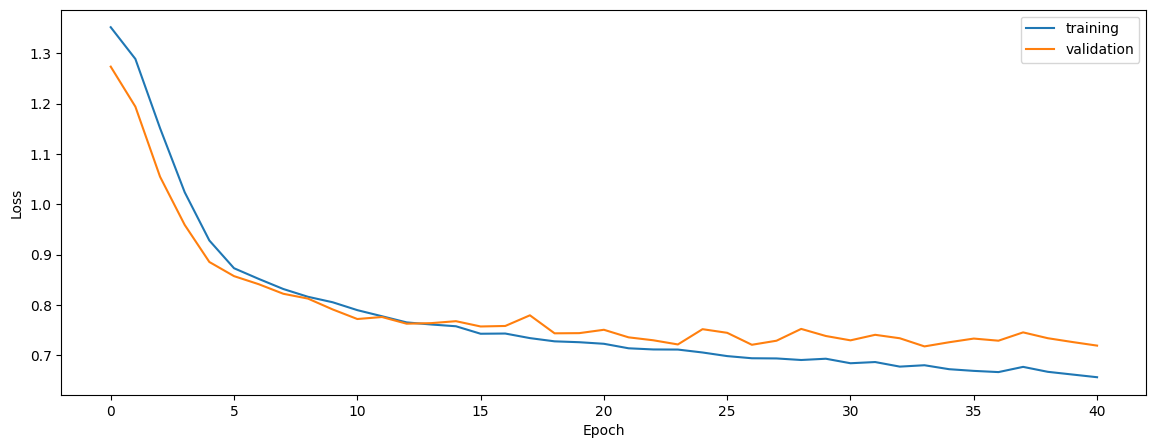

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7575404549696464
0.7479863765142953
0.7674362721201553


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.7575404549696464
0.7479863765142953
0.7674362721201553


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7550106109442545
0.7605528658829404
0.7682366467098691


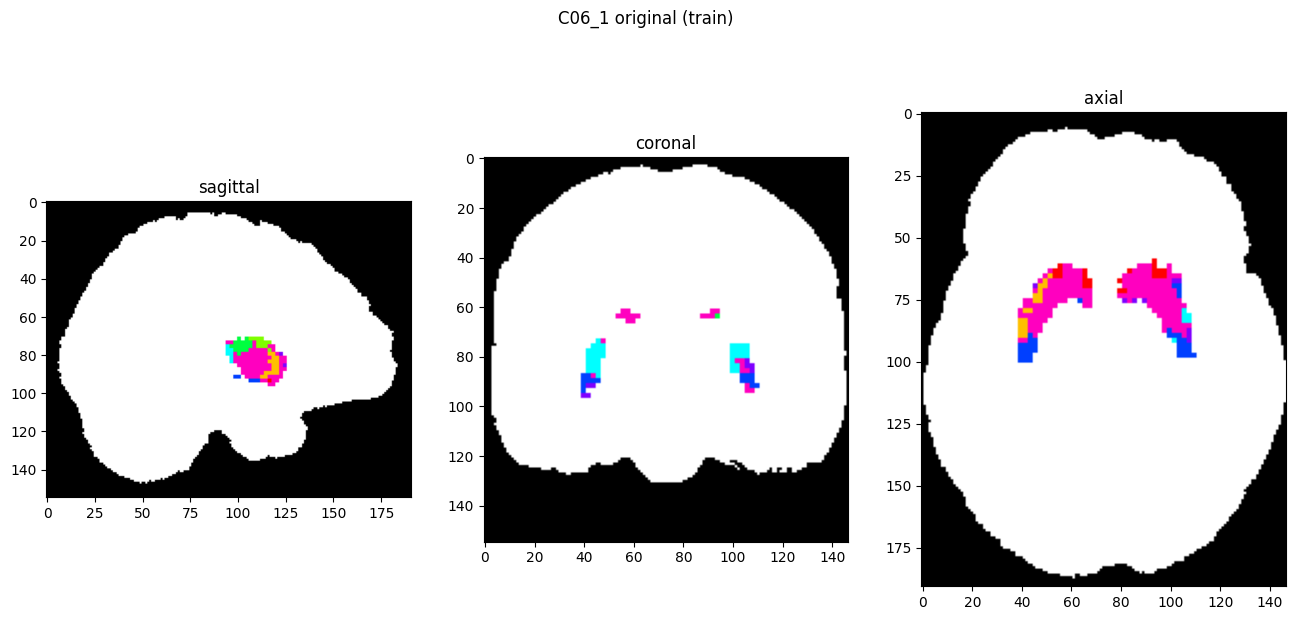

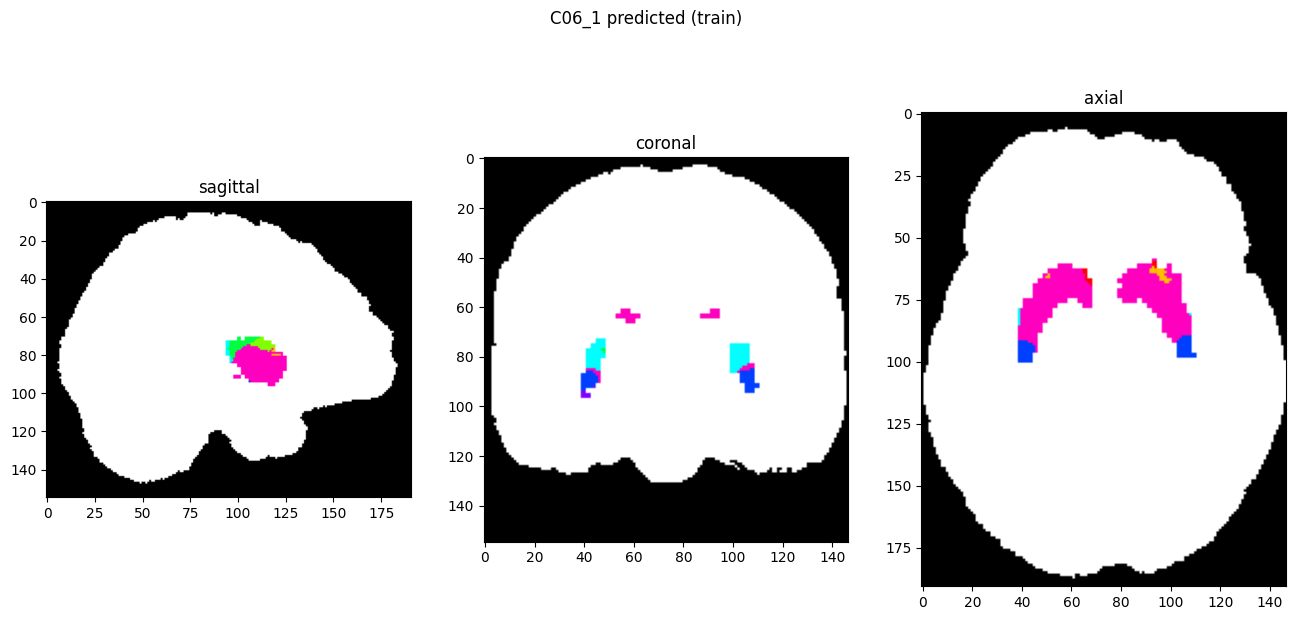

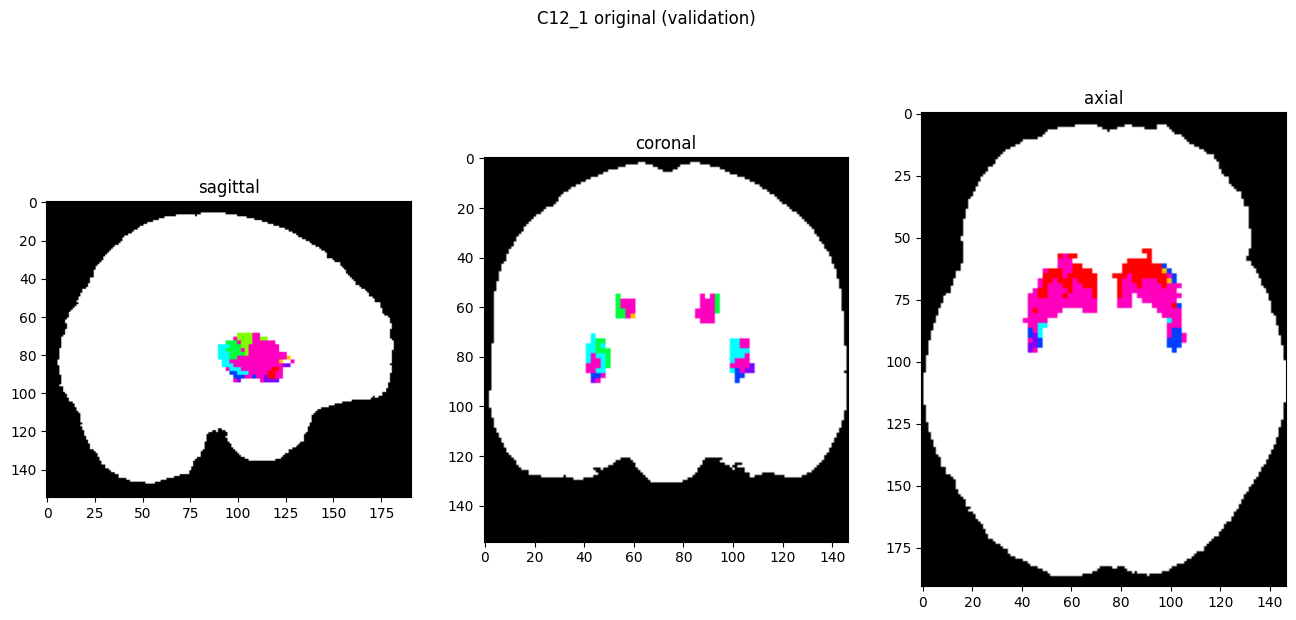

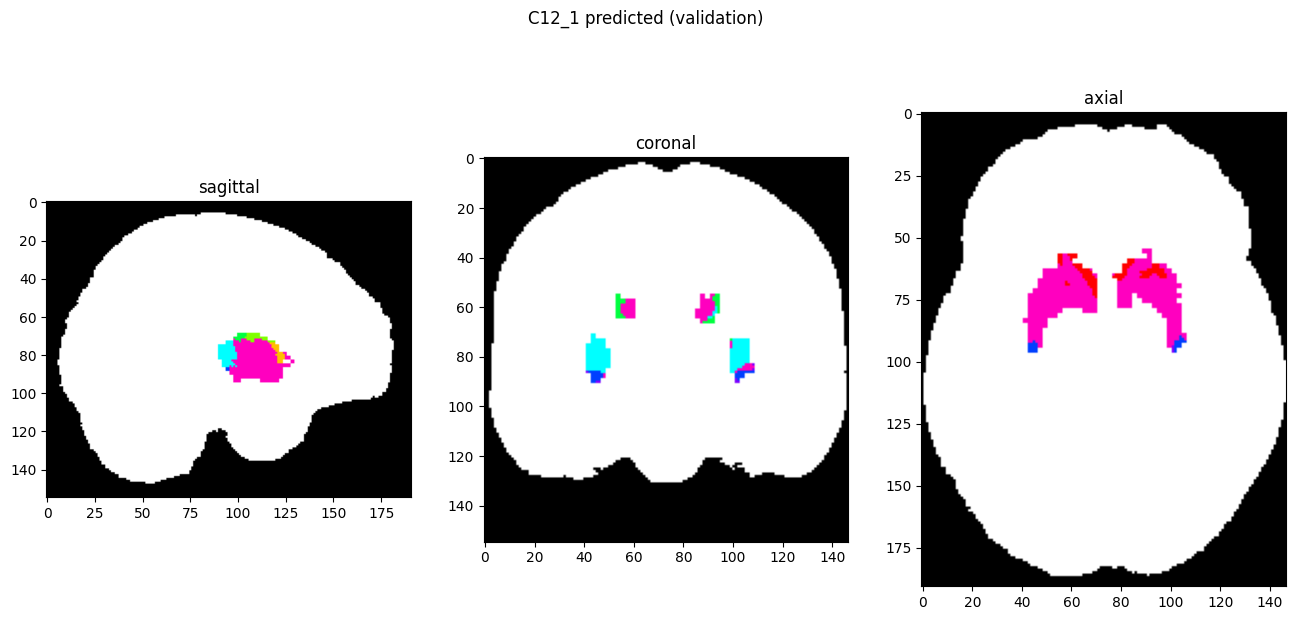

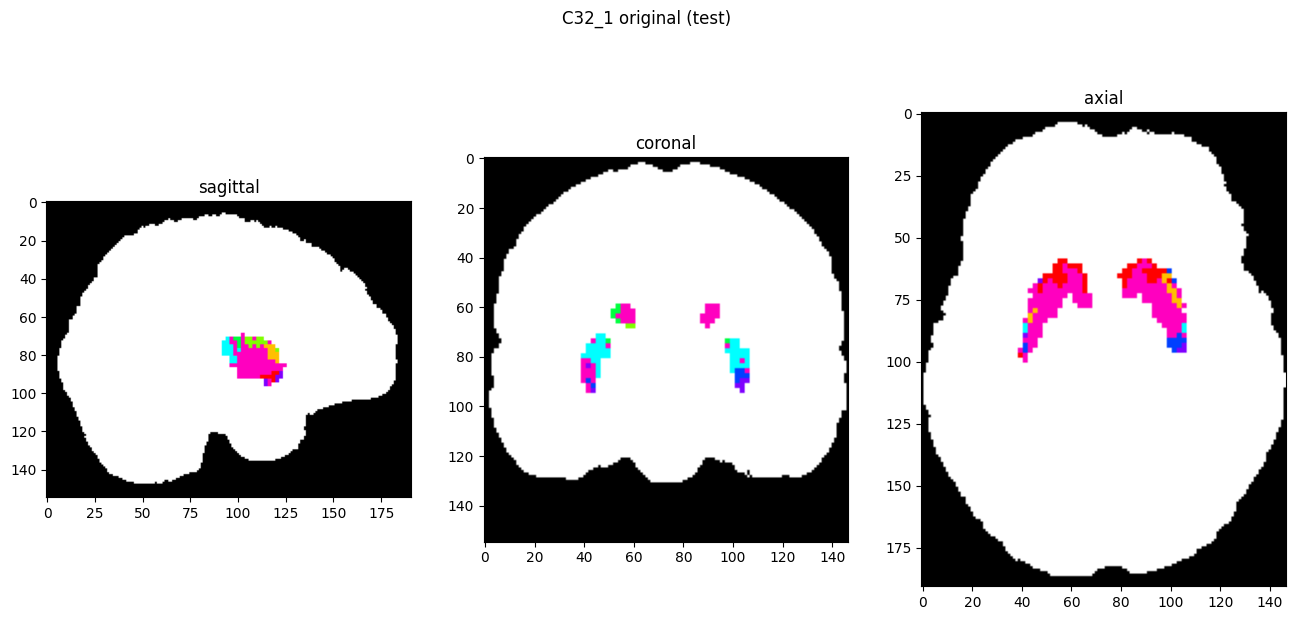

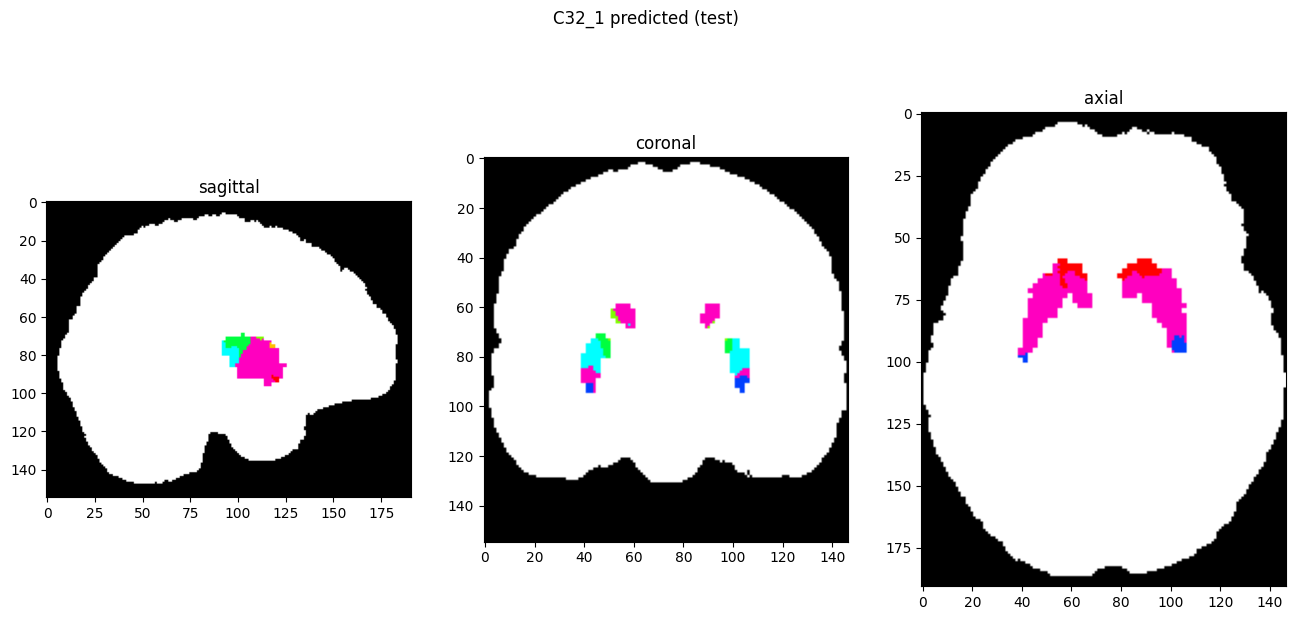

In [10]:
showResults(model, gen, threshold=0)